In [259]:
import hiplot as hip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
import random
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import os
import uproot3 as uproot

from scipy.optimize import curve_fit
import scipy.stats as stats


import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [260]:
ofolder="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/results/"
os.system("mkdir -p "+ofolder)

0

In [781]:
def loadTheory(tbin):
    theory_pred_floc="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/theory_pred/"
    ''' Load the theory curves for the different m-projections '''
    theoryCurves=pd.read_csv(theory_pred_floc+"Waves_bin"+str(tbin)+".txt",sep='  ',
                           names=["D0++", "D1++", "D2++", "D1--", "D0+-", "D1+-"], engine='python')
    theoryCurves=theoryCurves.reset_index()
    theoryCurves.rename(columns={"index":"mass"},inplace=True)
    return theoryCurves

def loadMergedPols(fileName,histBaseName,pols):
    '''
    We use amptools' plotter program to make histograms that were output into separate root files
    Use this function to load the root file and grab the histogram you want ~ integrated over some set of polarizations
    '''
    totalValues=0
    for pol in pols:
        hist=uproot.open(fileName)["EtaPi0_"+pol+"_"+histBaseName]
        edges=hist.edges
        width=edges[1]-edges[0]
        value=hist.values
        totalValues+=value
    return totalValues, edges, width

def relBW(x,particle_mass,width):
    ''' Equation for relativistic breit-wigner'''
    gamma=np.sqrt(particle_mass*particle_mass*(particle_mass*particle_mass+width*width))
    k=2*np.sqrt(2)*particle_mass*width*gamma/np.pi/np.sqrt(particle_mass*particle_mass+gamma)
    return k / ((x*x - particle_mass*particle_mass)**2 + (particle_mass*width)**2)

def constructAltTheory(tbin):
    '''
    Everytime we call this we have to load all 5 t bins since we have to keep the same proportions across t-bins
    '''
    theories=[loadTheory(i).iloc[:,1:].sum() for i in range(1,6)]
    theories=[theory/theories[0]["D2++"] for theory in theories]
    theory_masses=loadTheory(1).mass
    theory_waves=loadTheory(1).iloc[:,1:].columns
    
    mapWaves = {wave:relBW(loadTheory(1).mass,1.3182,0.1134)*theories[tbin-1][wave] for wave in theory_waves}
    mapWaves["mass"]=theory_masses
    mapWaves=pd.DataFrame(mapWaves)
    return mapWaves

def getYield(files):
    ''' Quickly get the yield in an tree by integrating the weights '''
    sums=0
    for file in files:
        tmp=uproot.open(file)["kin"].arrays(["Weight"],outputtype=pd.DataFrame)
        sums+=tmp["Weight"].sum()
    return sums

def combineBR(br1,br2,br3):
    ''' Combine 3 branching ratios by multiplication and propagate their uncertainties '''
    br=br1[0]*br2[0]*br3[0]
    brErr=br*np.sqrt((br1[1]/br1[0])**2+(br2[1]/br2[0])**2+(br3[1]/br3[0])**2)
    return [br,brErr]


#################
def loadFitFractions(files):
    ''' 
    amptools' plotter program can also output yields + acceptance corrected yields
    In the current setup the acceptance corrected yields are normalized by the total corrected
    yield to obtain a fit fraction. We can just multiply by the total yield to get the corrected
    yield in a wave
    '''
    etapi_plotter_ofile="etapi_plotter_output.log"
    waveInts_ts={}
    waveIntErrs_ts={}
    totals=[]
    for file in files:
        fname=file+"/"+etapi_plotter_ofile
        with open(fname) as fin:
            for line in fin:
                if "TOTAL EVENTS" in line:
                    total=float(line.split("=")[1].split("+-")[0].rstrip().lstrip())
                    total_err=float(line.split("=")[1].split("+-")[1].rstrip().lstrip())
                if line.startswith("FIT FRACTION") and "::" not in line:
                    wave=line.split(" ")[2]
#                     if "+" in wave or "-" in wave:
#                         continue
                    waveInt=float(line.split(" ")[4].rstrip().lstrip())
                    waveInt_err=float(line.split(" ")[6].rstrip().lstrip())
                    
                    if wave in waveInts_ts:
                        waveInts_ts[wave].append(waveInt)
                        waveIntErrs_ts[wave].append(waveInt_err)
                    else:
                        waveInts_ts[wave]=[waveInt]
                        waveIntErrs_ts[wave]=[waveInt_err]
        totals.append(total)
    
    waveInts_ts={k:np.array(v) for k,v in waveInts_ts.items()}
    waveIntErrs_ts={k:np.array(v) for k,v in waveIntErrs_ts.items()}
    
    return waveInts_ts, waveIntErrs_ts, totals

In [262]:
#######################################
###### Make things look prettier #######
#######################################

prettyWave={
    "S0++":"S_{0}^{+}",
    "D2-+":"D_{-2}^{+}",
    "D1-+":"D_{-1}^{+}",
    "D0++":"D_{0}^{+}",
    "D1++":"D_{1}^{+}",
    "D2++":"D_{2}^{+}",
    "S0+-":"S_{0}^{-}",
    "D2--":"D_{-2}^{-}",
    "D1--":"D_{-1}^{-}",
    "D0+-":"D_{0}^{-}",
    "D1+-":"D_{1}^{-}",
    "D2+-":"D_{2}^{-}",
    "D2-+_pD2-+":"D_{-2}^{+}",
    "D1-+_pD1-+":"D_{-1}^{+}",
    "D0++_pD0++":"D_{0}^{+}",
    "D1++_pD1++":"D_{1}^{+}",
    "D2++_pD2++":"D_{2}^{+}",
    "S0+-_pS0+-":"S_{0}^{-}",
    "D2--_pD2--":"D_{-2}^{-}",
    "D1--_pD1--":"D_{-1}^{-}",
    "D0+-_pD0+-":"D_{0}^{-}",
    "D1+-_pD1+-":"D_{1}^{-}",
    "D2+-_pD2+-":"D_{2}^{-}",
}

rearrangeWaveNotation={
    "S0+":"S0++",
    "S0-":"S0+-",
    "D-2+":"D2-+",
    "D-2-":"D2--",
    "D-1+":"D1-+",
    "D-1-":"D1--",
    "D0+":"D0++",
    "D0-":"D0+-",
    "D1+":"D1++",
    "D1-":"D1+-",
    "D2+":"D2++",
    "D2-":"D2+-",
}
rearrangeWaveNotationErr={k+"_err":v+"_err" for k,v in rearrangeWaveNotation.items()}
rearrangeWaveNotation={**rearrangeWaveNotation,**rearrangeWaveNotationErr}

# Mass Independet Fit Results

In [263]:
def loadMassIndependentData(baseFolder,waveset,masses,factor=1.0,bsTag="",keep=[True,True,True]):
    '''
    [baseFolder]: location to look for the finalAmps+[bsTag] which should contain a folder [waveset]
    [factor]: should we keep likelihoods within this factor of the best?
    [keep]: what data should we keep? only [converged, best likelihood, smallest err]
    '''
    keepConvergedOnly, keepBestLikelihoodOnly, keepSmallestErrorOnly = keep
    
    width=masses[1]-masses[0]
    masses=(masses)[:-1]+width/2
    binToMass={binNum:mass for binNum,mass in enumerate(masses)}

    datasets=[]
    totalFits=0
    filteredFits=0
    if not os.path.exists(baseFolder):
        print("folder does not exist! skipping: "+baseFolder)
        return None
    base=baseFolder+"finalAmps"+bsTag+"/"+waveset
    print("loading results in: "+base)
    for binNum in range(0,len(masses)):
        fullData=pd.read_csv(base+"/amplitudes-binNum"+str(binNum)+".txt",delimiter="\t")#,nrows=50)
        fullData["binNum"]=binNum
        totalFits+=len(fullData)

        # Convert datatypes
        ampCols=[tmp for tmp in fullData.columns if tmp not in ["status","likelihood","binNum","iteration","solution"]]
        fullData[ampCols]=fullData[ampCols].astype("float")

        # Filter results
        if keepConvergedOnly:
            fullData=fullData[fullData.status=="C"]
        if keepBestLikelihoodOnly:
            bestLikelihoods=fullData.groupby("binNum").likelihood.min()
            fullData=fullData[fullData.likelihood<=bestLikelihoods.values[0]*factor] # likelihoods within factor of the best is kept
        fullData.columns=[rearrangeWaveNotation[col] if col in rearrangeWaveNotation.keys() else col for col in fullData.columns]
        if keepSmallestErrorOnly:
            fullData=fullData[fullData["S0++_err"]==fullData["S0++_err"].min()]

        filteredFits+=len(fullData)
        datasets.append(fullData)

    print("\tt - total entries pre filtering {0}".format(totalFits))
    print("\tt - total entries post filtering {0}".format(filteredFits))
    datasets=pd.concat(datasets)
    datasets["mass"]=datasets.binNum.map(binToMass)
    datasets=datasets.reset_index(drop=True)

    return datasets

def plotSpecificAmps(inputDF,df,lms,outFile,axes=None,**kwargs):
    '''
    inputDF: dataframe contain the input mass histogram
    df: dataframe containing the amplitudes
    lms: lm choices
    outFile: save the figure to this location. IF "" then do not save anything
    '''
    #### SETUP
    fontsize=24
    varX="mass"
    signs=["+","-"]
    colors=["indianred","royalblue"]
    kwargs={"markersize":0, "linewidth":5, "fmt":"."}
    useBSerrs=True
    
    #### AXES RELATED
    nrows=int(np.floor(np.sqrt(len(lms))))
    ncols=int(np.ceil(np.sqrt(len(lms))))
    if nrows*ncols<len(lms):
        nrows+=1
    if axes is None:
        fig,axes=plt.subplots(nrows,ncols,figsize=(ncols*8,5*nrows))#,sharey=True,sharex=True)
    print("creating figure with {} rows and {} cols".format(nrows,ncols))
    axes=axes.flatten()
    mapAmpToAx={amp:i for i,amp in enumerate(lms)}
    mproj=[wave[-1] if wave[-1] in {"+","-"} else "" for wave in lms]
    latexAmps=[r'${0}_{{{1}}}$'.format(wave[0],wave[1]) for wave in lms]
    latexAmpsRef=[r'${0}_{{{1}}}"$'.format(wave[0],wave[1]) for wave in lms]
        
    #### Loop over waves and reflectivites and plot it
    for iref,ref in enumerate(["+","-"]):
        for i,amp in enumerate(lms):
            if iref==0:
                hep.histplot((inputDF.intensity,np.linspace(mi_lowMass,mi_upMass,mi_nbins+1)),c='black',label="Total",ax=axes[i])
            iax=mapAmpToAx[amp]
            wave=amp+ref
            if wave not in df.columns:
                continue
            label=latexAmps[i].split("}")
            label=label[0]+"}^{"+ref+"}"+label[1]
            print(wave)
            
            if useBSerrs:
                axes[i].errorbar(mi_df.mass+0.0075,mi_df[wave],yerr=[lstds[wave+"_err"],ustds[wave+"_err"]],c=colors[iref],label=label,**kwargs)
            else:
                axes[i].errorbar(mi_df.mass-0.0075,mi_df[wave],yerr=mi_df[wave+"_err"],c=colors[iref],label=label,**kwargs)
            axes[i].set_ylim(0)
            axes[i].set_xlim(inputDF[varX].min()*0.95,inputDF[varX].max()*1.05)
            axes[i].legend()

    for i in range(0,len(lms)):
        axes[i].legend(markerscale=3,prop={"size":18})
    for i in np.arange((nrows-1)*ncols,nrows*ncols):
        axes[i].set_xlabel(r"M($\eta\pi)$",size=fontsize)
    for i in np.arange(0,nrows*ncols,ncols):
        axes[i].set_ylabel("Intensity / 40 MeV",size=fontsize)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    if outFile!="":
        plt.savefig(outFile)
    
    return axes

def loadPlotterLog(base):
    '''
    etapi_plotter outputs a log file containing the corrected yields and fit fractions.
       this program loads the data
    '''
    fractions={}
    with open(base+"/etapi_plotter_output.log") as log:
        for line in log.readlines():
            if line.startswith("TOTAL"):
                entries=int(line.split(" ")[3].rstrip().lstrip())
                fractions["entries"]=entries
            if line.startswith("FIT FRACTION"):
                key=line.split(" ")[2].rstrip().lstrip()
                val=line.split(" ")[4].rstrip().lstrip()
                fractions[key]=float(val)*entries
    return fractions

def load_kmatrix(base,wave,yieldMap,binNorm):
    '''
    Load the Kmatrix mass dependent fit results (used for getting the generated curves)
    '''
    fileLoc=base+"etapi_plot_S0+-_S0++_D0+-_D0++_D2+-_D2++.root"
    extraYieldNorm=loadMergedPols(fileLoc,"Metapidat",["000"])[0]/loadMergedPols(fileLoc,"Metapiacc",["000"])[0]
    
    fileLoc=base+"etapi_plot_"+wave+".root"
    print(f"loading: {fileLoc}")
    assert(os.path.exists(fileLoc))
    histacc,edgesacc,_=loadMergedPols(fileLoc,"Metapiacc",["000"])
    histacc*=binwidth/(edgesacc[1]-edgesacc[0])
    histacc*=extraYieldNorm
    
    return histacc, edgesacc

def getMatchingValues(array1,array2,array3):
    '''
    find indicies of array2 that match the value of array1 and use
    that those indices to index into array3
    '''
    matchingIdxs=[]
    for val1 in array1:
        for i,val2 in enumerate(array2):
            if val1==val2:
                matchingIdxs.append(i)
    match=np.array(array3)[matchingIdxs]
    assert(len(match)==len(array1))
    return match

In [264]:
#################
# Basic Setup
#################
mi_lowMass=0.8
mi_upMass=1.8
mi_nbins=25
mi_waveset="D0+_D0-_D2+_D2-_S0+_S0-"
mi_waveset_vec=mi_waveset.split("_")
mi_waveset_vec=[rearrangeWaveNotation[ele] for ele in mi_waveset_vec]

mi_baseFolder="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr/"

In [265]:
#################
# Load input histograms
#################
inputDF=pd.read_csv(mi_baseFolder+"/drawAmptoolsVar/corrected_yields.txt",header=None,delimiter=" ",
                   names=["mass","intensity"])
inputDF["binNum"]=inputDF.index

#################
# Load Nominal results
#################
mi_df=loadMassIndependentData(mi_baseFolder,mi_waveset,
                              np.linspace(mi_lowMass,mi_upMass,mi_nbins+1),keep=[True,False,False])
bestLikelihoods=mi_df.groupby("binNum").likelihood.min()
## THERE IS SOMETHING WONKY GOING ON WITH BIN 12, LETS JUST MANUALLY SELECT A SLIGHTLY WORSE SOLUTION
bestLikelihoods[12]=mi_df[mi_df.binNum==12].likelihood.unique()[0]
dfs=[]
for binNum in range(mi_nbins):
    df=mi_df[mi_df.binNum==binNum]
    df=df[df.likelihood<=bestLikelihoods[binNum]].iloc[0]
    dfs.append(df)
mi_df=pd.concat(dfs,axis=1).T.reset_index(drop=True)
mi_df.mass=mi_df.mass.astype(float)

#################
# Load Bootstrap results
#################
mi_bs=loadMassIndependentData(mi_baseFolder,mi_waveset,
                              np.linspace(mi_lowMass,mi_upMass,mi_nbins+1),bsTag="_bs_data1x_bkgnd1x",keep=[True,False,False])

# Extract 16th, 50th, 84th percentiles and standard deviation
lstds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.16).reset_index()
mstds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.50).reset_index()
ustds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.84).reset_index()
stds=mi_bs.groupby("mass")[mi_waveset_vec].std().reset_index()

ustds[mi_waveset_vec] = ustds[mi_waveset_vec]-mstds[mi_waveset_vec]
lstds[mi_waveset_vec] = mstds[mi_waveset_vec]-lstds[mi_waveset_vec]

renameMap={ele:ele+"_err" for ele in mi_waveset_vec}
lstds=lstds.rename(columns=renameMap)
ustds=ustds.rename(columns=renameMap)
stds=stds.rename(columns=renameMap)
mi_waveset_err_vec=[ele+"_err" for ele in mi_waveset_vec]

loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr/finalAmps/D0+_D0-_D2+_D2-_S0+_S0-
	t - total entries pre filtering 750
	t - total entries post filtering 686
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr/finalAmps_bs_data1x_bkgnd1x/D0+_D0-_D2+_D2-_S0+_S0-
	t - total entries pre filtering 12500
	t - total entries post filtering 11533


creating figure with 2 rows and 2 cols
S0++
D0++
D2++
S0+-
D0+-
D2+-
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_S0++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_S0+-.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D0++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D0+-.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D2++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D2+-.root


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


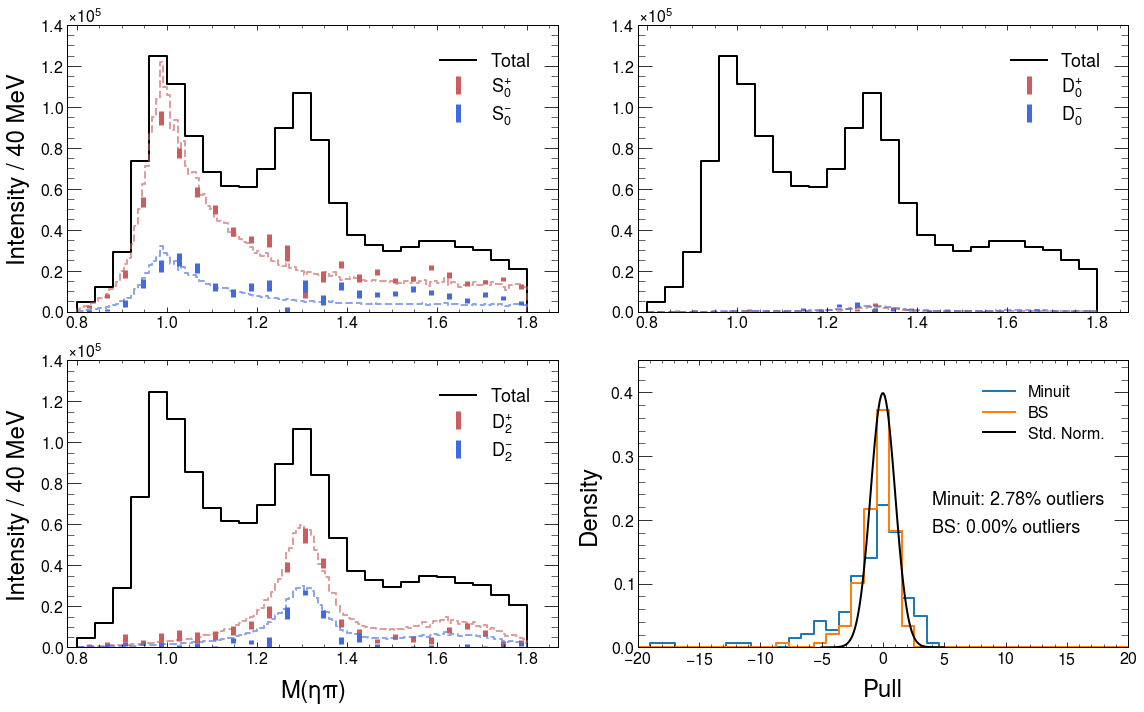

In [266]:
### Overlay kmatrix generated results and save the pulls
axes=plotSpecificAmps(inputDF,mi_df,["S0+","D0+","D2+"],"")

pull_minuit=[]
pull_bs=[]
mi_centers=np.around(mi_df.mass.values,5)

kmatrix_base="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/"
yieldMap=loadPlotterLog(kmatrix_base)
for i,amp in enumerate(["S0+","D0+","D2+"]):
    for ref,c in zip(["+","-"],["indianred","royalblue"]):
        wave=amp+ref
        binwidth=(inputDF.mass[1]-inputDF.mass[0])
        acc,edges=load_kmatrix(kmatrix_base,wave,yieldMap,binwidth)
        centers=np.around(edges[:-1]+(edges[1]-edges[0])/2,5)
#         axes[i].plot(centers,acc,c=c,linewidth=2, linestyle='--',alpha=0.6)
        hep.histplot(acc,edges,c=c,linewidth=2, linestyle='--',alpha=0.6,ax=axes[i])
        predictions=getMatchingValues(mi_centers,centers,acc)
        pull_minuit.append((mi_df[wave]-predictions)/(mi_df[wave+"_err"]))
        pull_bs.append((mi_df[wave]-predictions)/(ustds[wave+"_err"]+lstds[wave+"_err"])) ## yes its adding ustd and lstd since lstd has implict subtraction
pull_minuit=np.array(pull_minuit).flatten()
pull_bs=np.array(pull_bs).flatten()
        
### Draw the pulls
percentOutside=[]
for pulls,label in zip([pull_minuit,pull_bs],["Minuit","BS"]):
    pulls=pulls[(pulls>np.quantile(pulls,0.02))*(pulls<np.quantile(pulls,0.98))]
    h=np.histogram(pulls,bins=np.linspace(-20,20,40))
    percentOutside.append((1-h[0].sum()/len(pulls))*100)
    hep.histplot(h,ax=axes[3],density=True,label=label)
x = np.linspace(-5, 5, 100)
axes[3].plot(x, stats.norm.pdf(x, 0, 1),c='black',label="Std. Norm.")
axes[3].text(0.6,0.5,"Minuit: {:0.2f}% outliers".format(percentOutside[0]),size=18,transform=axes[3].transAxes)
axes[3].text(0.6,0.40,"BS: {:0.2f}% outliers".format(percentOutside[1]),size=18,transform=axes[3].transAxes)
axes[3].set_ylabel("Density",size=24)
axes[3].set_xlabel("Pull",size=24)
axes[3].legend()

plt.tight_layout()
plt.savefig(ofolder+"/kmatrix_compare_gen_and_pwa_results.pdf")

# GlueX Data

In [700]:
def loadDF(fileName,treeName,cols):
    ''' Function to load a root file '''
    tree=uproot.open(fileName)[treeName]
    df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    return df

def loadDataInCfgFile(cfg):
    ''' Grab the files listed in a amptools config file '''
    keys=["LOOPDATA","LOOPBKGND","LOOPACCMC"]
    dfs={}
    with open(cfg) as c:
        for line in c.readlines():
            if line.startswith("loop") and "root" in line:
                tmp=line.rstrip().lstrip().split(" ")
                df=[]
                for key in keys:
                    if tmp[1]==key:
                        for f in tmp[2:]:
                            d=loadDF(f,"kin",["Weight","AccWeight","Mpi0eta","cosTheta_eta_hel","cosTheta_eta_gj","Mpi0p","Mpi0","Meta"])
                            if key=="LOOPBKGND":
                                d.Weight*=-1
                            df.append(d)
                        dfs[key]=pd.concat(df)
    return dfs

In [418]:
floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/"

loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/010020/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/0200325/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/0325050/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/050075/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/st

/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:122: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


array([['S0++', 'D0++', 'D1++', 'D2++']], dtype='<U4')

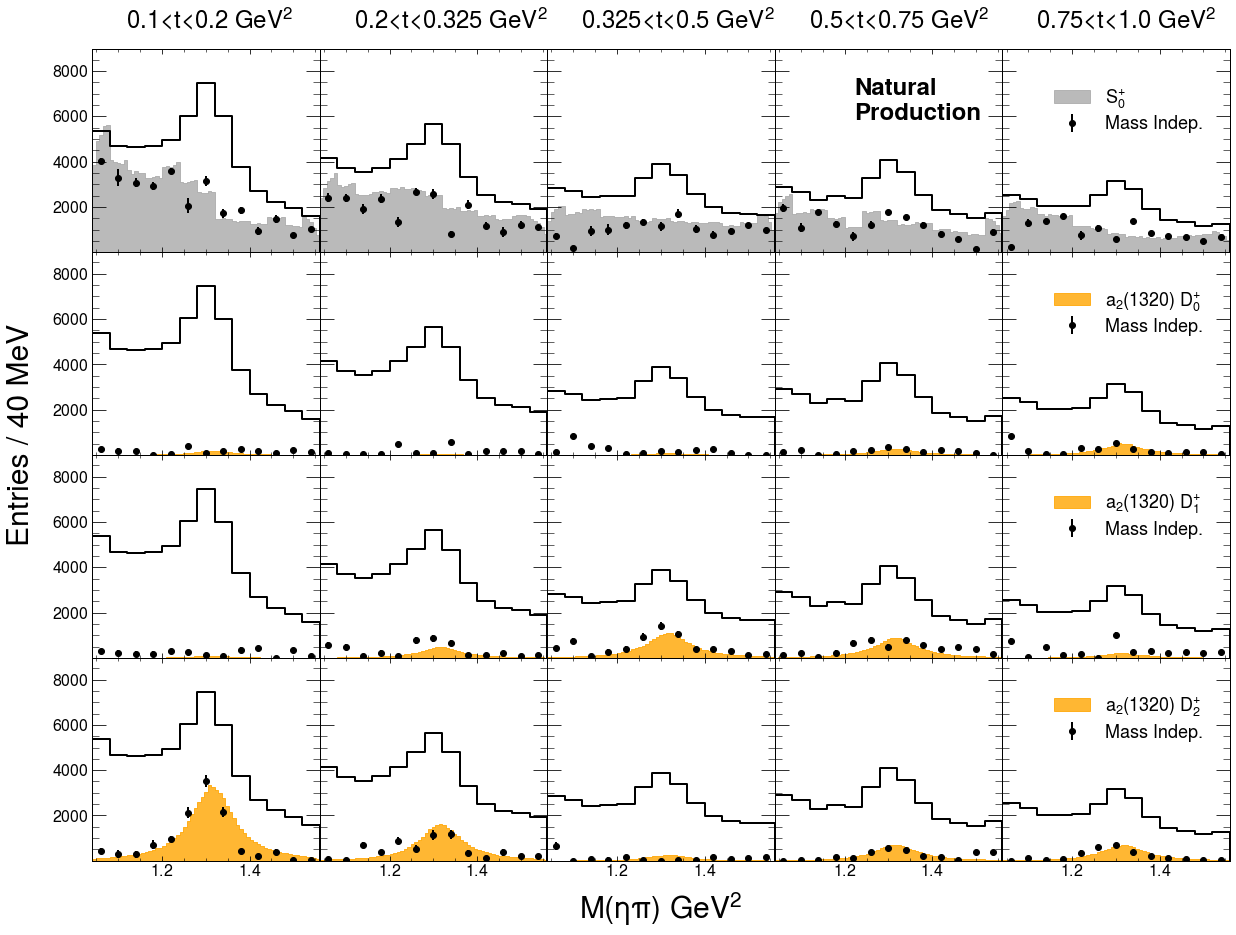

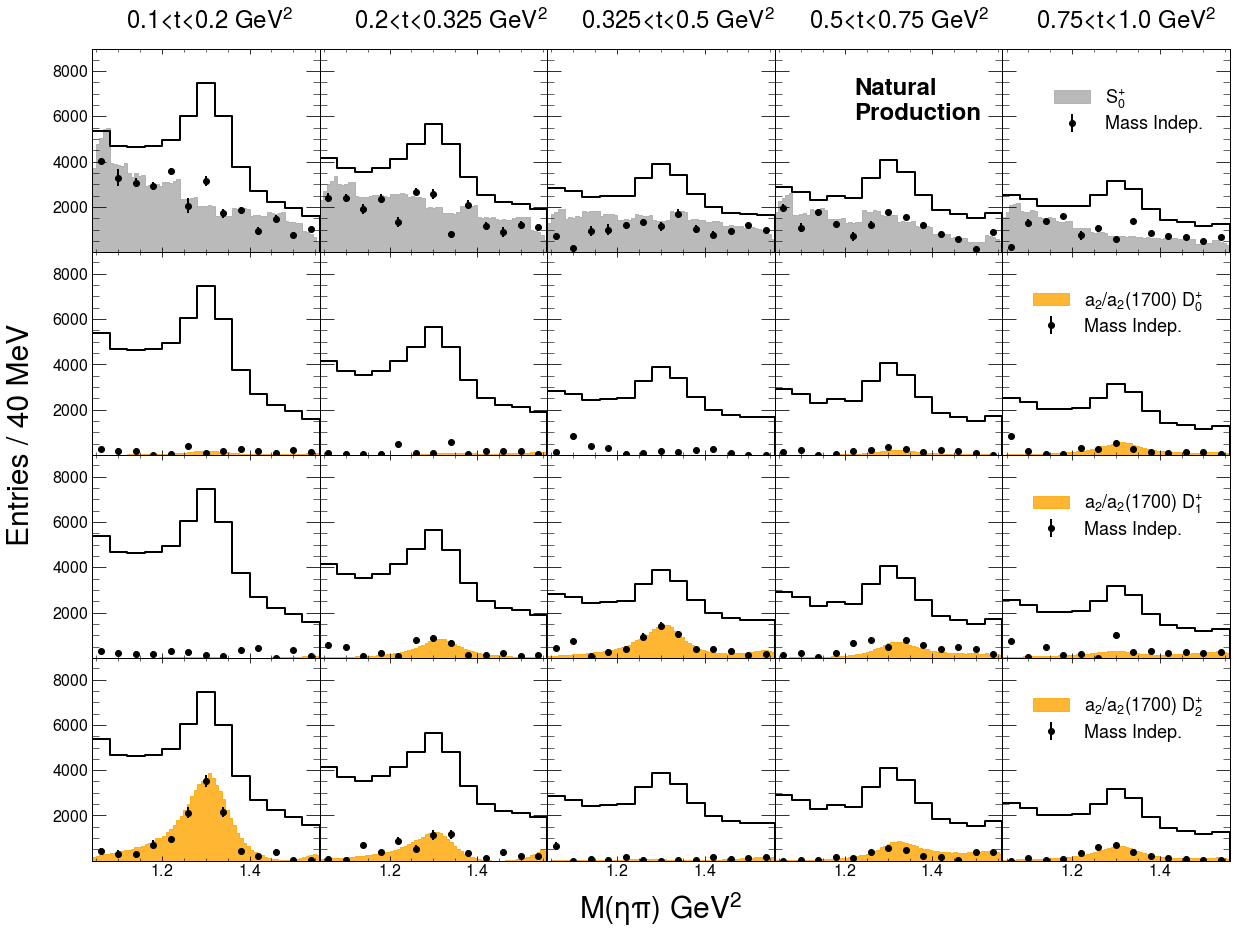

In [268]:
#################
# Basic Setup
#################
mi_lowMass=1.04
mi_upMass=1.56
mi_nbins=13
mi_waveset="D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-"
mi_waveset_vec=mi_waveset.split("_")
mi_waveset_vec=[rearrangeWaveNotation[ele] for ele in mi_waveset_vec]

ts=["010020","0200325","0325050","050075","075100"]
midts=[0.15,0.2625,0.4125,0.625,0.875]
tLabels=[f"0.1<t<0.2 $GeV^2$", f"0.2<t<0.325 $GeV^2$", f"0.325<t<0.5 $GeV^2$", f"0.5<t<0.75 $GeV^2$", f"0.75<t<1.0 $GeV^2$"]

mi_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_t010020_m104180_noAccCorr/"
mis=[]
for t in ["010020","0200325",'0325050','050075','075100']:
    mi_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/"
    mi=loadMassIndependentData(mi_floc+t+"/",mi_waveset,
                                  np.linspace(mi_lowMass,mi_upMass,mi_nbins+1))
    mi['t']=t
    mis.append(mi)
mis=pd.concat(mis)

md_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD/"
plotWaves(md_floc,mis,"m104156_a2",selectRef=[1],resonances=[""],plotMI=True,plotTheory=False,plotData=True)
md_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD_includesa2p_bestOutOfTwo/"
plotWaves(md_floc,mis,"m104156_a2a2prime",selectRef=[1],resonances=["both"],plotMI=True,plotTheory=False,plotData=True)

In [269]:
import scipy.stats

def extractValue(floc,search):
    '''
    Extract value given a search string, i.e. bestMinimum in file location, floc
    '''
    with open(floc) as f:
        for line in f.readlines():
            if search in line:
                likelihood=line.split("\t")[-1].rstrip()
                break
    return float(likelihood)

def extractNParameters(floc):
    '''
    Extracting the number of free parameters not really easy, we will search the logs for 
       the specified [search] string and search for npars around there
    input: floc - file location
    output: npars - number of parameters
    '''
    def isNumeric(s):
        if len(s)==0:
            return False
        else:
            return s[0].isdigit()
    
    search="PARAMETER DEFINITIONS"
    with open(floc) as f:
        lines=np.array([ele.rstrip().lstrip() for ele in f.readlines()])
    idx=[i for i in range(len(lines)) if search in lines[i]][0]
    lines=lines[idx:idx+200] # Hopefully there isnt more than 200 parameters...
    lines=[l.split(" ")[0] for l in lines]
    lines=[int(l) for l in lines if l.isnumeric()]
    if np.prod(np.array(lines)==np.arange(len(lines))+1):
        npars=len(lines)
    return npars


def extractPvalue(f1,a1,f2,a2):
    '''
    Extract p-values given 2 file locations and the attempt number
    '''
    min1=extractValue(f1+"etapi_result"+a1+".fit","bestMinimum")
    npar1=extractNParameters(f1+"fitAttempt"+a1+".log")
    min2=extractValue(f2+"etapi_result"+a2+".fit","bestMinimum")
    npar2=extractNParameters(f2+"fitAttempt"+a2+".log")

    deltaLL=min2-min1
    deltaNPars=npar1-npar2
    pvalue=1-stats.chi2.cdf(deltaLL, deltaNPars)
    return deltaLL, deltaNPars, pvalue

def loadLastAttempt(f):
    fs=os.listdir(f)
    attempts=[int(float(f.split("log")[0].split("fitAttempt")[1])) for f in fs if "fitAttempt" in f]
    attempt=max(attempts)
    return str(attempt)

performance=[]
for t in ts:
    f1="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD_includesa2p_bestOutOfTwo/"+t+"/"
    f2="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD/"+t+"/"
    a1=loadLastAttempt(f1)
    a2=loadLastAttempt(f2)
    performance.append(extractPvalue(f1,a1,f2,a2))
performance=np.array(performance)

In [270]:
### Alternative to Null
performance=pd.DataFrame(performance,columns=["DeltaLL","DOF","p-value"])
performance["t"]=tLabels
performance=performance[["t","DeltaLL","DOF","p-value"]]
performance

,t,DeltaLL,DOF,p-value
0,0.1<t<0.2 $GeV^2$,124.721544,14.0,0.000000e+00
1,0.2<t<0.325 $GeV^2$,52.233357,14.0,2.567405e-06
2,0.325<t<0.5 $GeV^2$,353.829951,14.0,0.000000e+00
3,0.5<t<0.75 $GeV^2$,100.882494,14.0,3.219647e-15
4,0.75<t<1.0 $GeV^2$,333.504934,14.0,0.000000e+00


# Phase difference

In [271]:
floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD_includesa2p_bestOutOfTwo/010020/etapi_result0.fit"

In [272]:
def loadBWresults(ref="Positive"):
    bwProdCoef=[line for line in lines if "EtaPi0_000::"+ref+"Re" in line]
    bwProdCoef=dict(line.split("\t") for line in bwProdCoef)
    amps=list(set([line.split("_")[-2].split("::")[-1] for line in lines if "EtaPi0_000::"+ref+"Re" in line]))
    prefix="EtaPi0_000::"+ref+"Re::"
    return {amp:float(bwProdCoef[prefix+amp+"_re"])+1j*float(bwProdCoef[prefix+amp+"_im"]) for amp in amps}

def loadPcwiseResults(ref="Pos"):
    return {"pcwsBin_"+str(n)+ref: float(pcwise["pcwsBin_"+str(n)+"Re"+ref])+1j*float(pcwise["pcwsBin_"+str(n)+"Im"+ref]) for n in range(nbins)}


# https://en.wikipedia.org/wiki/Relativistic_Breit%E2%80%93Wigner_distribution 
###  gives us the propagator of the Rel. BW distribution but seems to be off by a factor of -1. The phase starts > pi
###  This is fine, since what we measure is the intensity and a -1 drops when squaring
# https://pdg.lbl.gov/2019/reviews/rpp2019-rev-resonances.pdf EQUATION 48.18
###  PDG also suggests that the denominator should be multiplied by -1 
def T(m,m0,Gamma):
#     return Gamma/2/(m0-m-1j*Gamma/2)
    gamma=np.sqrt(m0**2*(m0**2+Gamma**2))
    k=2*np.sqrt(2)*m0*Gamma*gamma/np.pi/np.sqrt(m0**2+gamma)
    return -1*np.sqrt(k)/((m**2-m0**2)+1j*m0*Gamma)

def mapPhases(phase):
#     return phase
    return (phase+2*np.pi)%(2*np.pi)

In [273]:
####################################################
# THIS BLOCK OF CODE LOADS THE FIT RESULTS AND ATTEMPTS TO PARSE IT TO EXTRACT
#    THE PRODUCTION COEFFICIENTS AND BW RESONANCE PARAMETERS
####################################################

with open(floc) as f:
    lines=f.readlines()
    lines=[line.rstrip().lstrip() for line in lines]
_lines=lines

interestingStartingWords=["EtaPi0_000","pcwsBin","a2"] # all pols constrained to equal, lets look at 0 only
lines=[line for line in lines if np.any([line.startswith(word) for word in interestingStartingWords])==1] # find important lines
lines=[line for line in lines if not "parScale" in line] # remove all parScale lines
lines=[line for line in lines if len(line.split("\t"))==2] # key value pairs are tab separated

# LOAD - Lines related to a2 resonance parameters
bwpars=[line for line in lines if "a2" in line]
bwpars=dict(line.split("\t") for line in bwpars)
bwpars={k:float(v) for k,v in bwpars.items()}

# LOAD - BW PRODUCTION COEFFICIENTS
bwPosRe=loadBWresults("Positive")
bwNegRe=loadBWresults("Negative")

# LOAD - Binning of the pcwise S-wave
samplePiecewiseLine=[line for line in _lines if "Piecewise" in line][0]
binning=samplePiecewiseLine.split(" ")[3:6]
binning=[float(binning[0]),float(binning[1]),int(binning[2])]
nbins=binning[2]
edges=np.linspace(binning[0],binning[1],binning[2]+1)
centers=edges[:-1]+(edges[1]-edges[0])/2

# LOAD - PIECEWISE BINNED PRODUCTION COEFFICIENTS
pcwise_pos=loadPcwiseResults("Pos")
pcwise_neg=loadPcwiseResults("Neg")

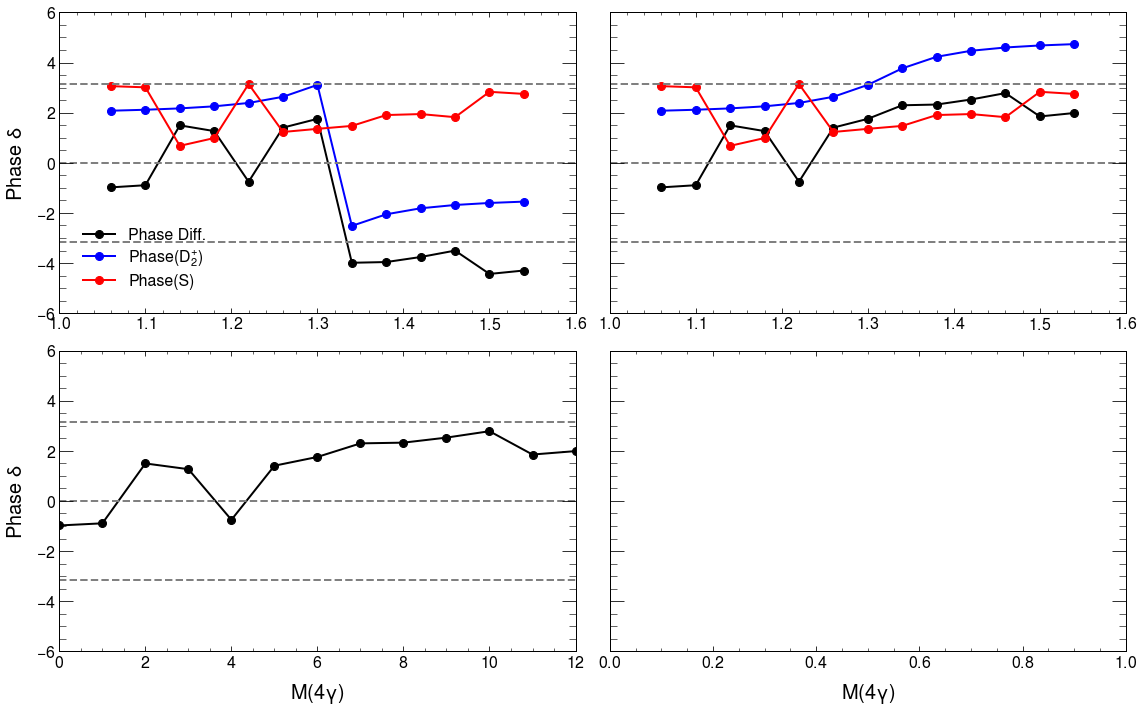

In [274]:
fig,axes=plt.subplots(2,2,figsize=(16,10),sharey=True)
axes=axes.flatten()

wave="D2++"
a2_bwProdCoef=bwPosRe[wave]
a2prime_bwProdCoef=bwPosRe["p"+wave]
a2_Ts=T(centers,bwpars["a2mass"],bwpars["a2width"])
a2prime_Ts=T(centers,bwpars["a2massprime"],bwpars["a2widthprime"])
S0p=np.array(list(pcwise_pos.values()))
S0n=np.array(list(pcwise_neg.values()))

### ---------------------------------
a2_bwPhase=np.angle(a2_bwProdCoef*a2_Ts)
a2prime_bwPhase=np.angle(a2prime_bwProdCoef*a2prime_Ts)
pcwisePhase=np.angle(S0p) if wave[-1]=="+" else np.angle(S0n)
phaseDiff=a2_bwPhase-pcwisePhase

axes[0].plot(centers,phaseDiff,c='black',marker='o',label="Phase Diff.")
axes[0].plot(centers,a2_bwPhase,c='blue',marker='o',label=f"$Phase({prettyWave[wave]})$")
axes[0].plot(centers,pcwisePhase,c='red',marker='o',label="Phase(S)")
axes[0].axhline(-np.pi,c='gray',linestyle='--')
axes[0].axhline(0,c='gray',linestyle='--')
axes[0].axhline(np.pi,c='gray',linestyle='--')
axes[0].legend()

### ---------------------------------
a2_bwPhase=mapPhases(np.angle(a2_bwProdCoef*a2_Ts))
a2prime_bwPhase=mapPhases(np.angle(a2prime_bwProdCoef*a2prime_Ts))
pcwisePhase=mapPhases(np.angle(S0p) if wave[-1]=="+" else np.angle(S0n))
phaseDiff=a2_bwPhase-pcwisePhase

axes[1].plot(centers,phaseDiff,c='black',marker='o',label="Phase Diff.")
axes[1].plot(centers,a2_bwPhase,c='blue',marker='o',label=f"$Phase({prettyWave[wave]})$")
axes[1].plot(centers,pcwisePhase,c='red',marker='o',label="Phase(S)")
axes[1].axhline(-np.pi,c='gray',linestyle='--')
axes[1].axhline(0,c='gray',linestyle='--')
axes[1].axhline(np.pi,c='gray',linestyle='--')

### ---------------------------------
b=S0p/abs(S0p)
a=a2_bwProdCoef*a2_Ts/abs(a2_bwProdCoef*a2_Ts)
c=np.log(b/a)
assert np.prod(c.real<1e-10)
p=(c*1j).real
axes[2].plot(p,marker='o',c='black')
axes[2].axhline(-np.pi,c='gray',linestyle='--')
axes[2].axhline(0,c='gray',linestyle='--')
axes[2].axhline(np.pi,c='gray',linestyle='--')


axes[0].set_ylabel(r"Phase $\delta$")
axes[2].set_ylabel(r"Phase $\delta$")
axes[2].set_xlabel(r"$M(4\gamma)$")
axes[3].set_xlabel(r"$M(4\gamma)$")
plt.tight_layout()

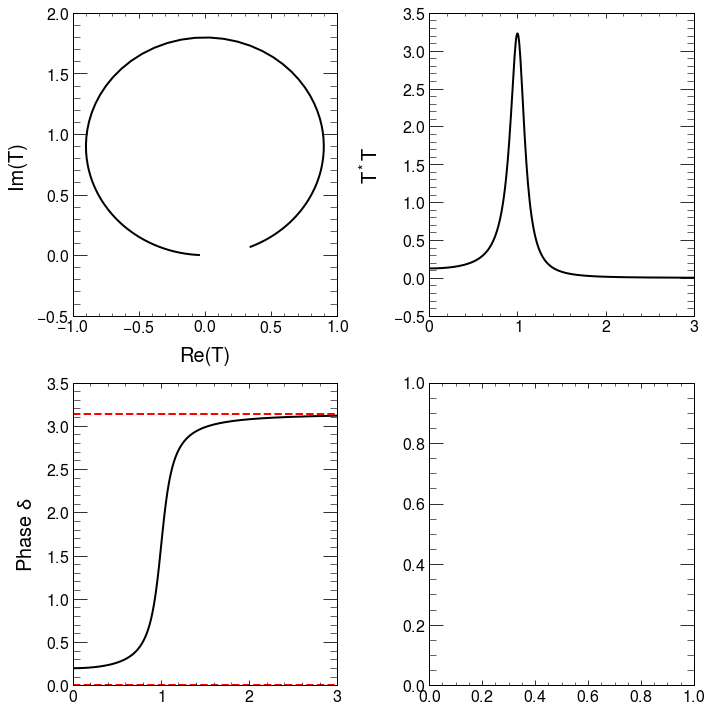

In [275]:
############################################
# TESTING THE CODE, MAKING THEORY PLOT
############################################

_m=np.linspace(0,3,500)
t=T(_m,1,0.2)
fig,axes=plt.subplots(2,2,figsize=(10,10))
axes=axes.flatten()

axes[0].plot(t.real,t.imag,c='black')
axes[0].set_xlabel("Re(T)")
axes[0].set_ylabel("Im(T)")

axes[1].plot(_m,(t*np.conjugate(t)).real,c='black')
axes[1].set_ylabel(r"$T^*T$")

axes[2].plot(_m,np.angle(t),c='black')
axes[2].set_ylabel(r"Phase $\delta$")
axes[2].axhline(0,c='red',linestyle='--')
axes[2].axhline(np.pi,c='red',linestyle='--')


plt.tight_layout()

# Hybrid Fit Results

In [818]:

########################################################
# OLDER FUNCTION THAT DOES NOT FOLLOW THE NEW DIRECTORY LAYOUT
########################################################
# def plotWaves(floc,mi_df,ofileTag,
#               selectRef=[0,1],
#               resonances=["","p"],
#               wavesets=np.array([["S0+-","D1--","D0+-","D1+-"],["S0++","D0++","D1++","D2++"]]),
#               plotMI=False,plotTheory=False,plotData=True,
#               histtype="fill"):
#     '''
#     md_floc: folder location containing the etapi_plotter root files
#     mi_df: dataframe containing the fit results for mass-indep fits
#     ofiletag: output file tag to include in the output file name -> positiveRef_[tag].pdf
#     refs: where 0,1 represents -,+ reflectivies to plot. i.e. [0,1] will plot both [1] will just plot + ref
#     resonaces=["","p"] where ""=a2 or "p"=a2prime or set resonances=["both"] to merge (for mass-indep comparison)
#     plotMI: should we plot the mass-independent fit results located in mi_df?
#     plotTheroy: should we overlay Vincent's predictions?
#     '''
#     fileName="etapi_plot_"
#     wavesets=wavesets[selectRef]
#     refs=np.array(["negativeRef","positiveRef"])[selectRef]
#     naturalities=np.array(["Unnatural\nProduction","Natural\nProduction"])[selectRef]
#     xlabel=r"$M(\eta\pi)$ $GeV^2$"
#     ylabel=r"Entries / 40 MeV"

#     #### Get the maximum value of the D2++ wave in the smallest t-bin so that we can scale all theory curves to it
#     histdat, _, width = loadMergedPols(floc+"010020/"+fileName+"D2++.root","Metapi_40MeVBindat",["000","045","090","135"])
#     histacc, _, widthacc = loadMergedPols(floc+"010020/"+fileName+"D2++.root","Metapiacc",["000","045","090","135"])
#     binScaleFactor=width/widthacc
#     maxD2pp=histacc.max()*binScaleFactor
#     theory=constructAltTheory(1)
#     scaleFactor=maxD2pp/theory["D2++"].max()    
#     for iws,waveset,ref,naturality in zip(range(len(wavesets)),wavesets,refs,naturalities):
#         fig,axes=plt.subplots(4,5,figsize=(20,14),sharex=True,sharey=True)
#         for prime in resonances:
#             for iw,wave in enumerate(waveset):
#                 for it,t,tLabel in zip(range(len(ts)),ts,tLabels):
#                     ############### Load the data to be plotted - ok to overwrite histdat and histacc now
#                     if wave[0]=="D":
#                         selectWave=prime+wave if prime in ["","p"] else wave+"_p"+wave
#                         if prime=="":
#                             histLabel=f"$a_2(1320)$ ${prettyWave[wave]}$"
#                         elif prime=="p":
#                             histLabel=f"$a_2(1700)$ ${prettyWave[wave]}$"
#                         else:
#                             histLabel=r"$a_2/a_2(1700)$"+f" ${prettyWave[wave]}$"
#                     else: #All non-D waves
#                         selectWave=prime+wave if prime in ["","p"] else wave
#                         histLabel=f"${prettyWave[wave]}$"
#                     fileLoc=floc+t+"/"+fileName+selectWave+".root"
#                     if not os.path.exists(fileLoc):
#                         continue
#                     histdat,edges,_=loadMergedPols(fileLoc,"Metapi_40MeVBindat",["000","045","090","135"])
#                     histbkg,_,_=loadMergedPols(fileLoc,"Metapi_40MeVBinbkg",["000","045","090","135"])
#                     values=histdat-histbkg
#                     histacc,edgesacc,_=loadMergedPols(fileLoc,"Metapiacc",["000","045","090","135"])
#                     valuesacc=histacc*binScaleFactor
#                     if plotData:
#                         hep.histplot(values,edges,c='black',ax=axes[iw,it])
#                     if wave[3]=="+" and (prime=="" or prime=="both"):
#                         color="darkgray" if wave[0]=="S" else "orange"
#                     if wave[3]=="+" and prime=="p":
#                         color="royalblue"
#                     if wave[3]=="-" and (prime=="" or prime=="both"):
#                         color="darkgray" if wave[0]=="S" else "orange"
#                     if wave[3]=="-" and prime=="p":
#                         color="royalblue"
#                     hep.histplot(valuesacc,edgesacc,color=color,ax=axes[iw,it],alpha=0.8,label=histLabel,histtype=histtype)

#                     #### Mass independent results
#                     if plotMI:
#                         mi=mi_df[mi_df.t==t]
#                         axes[iw,it].errorbar(mi.mass,mi[wave],yerr=mi[wave+"_err"],c='black',fmt='o',markersize=6,label="Mass Indep.")

#                     #### Theory curves
#                     if plotTheory:
#                         theory=loadTheory(it+1)
#                         theory=constructAltTheory(it+1)
#                         if wave in theory.columns and prime=="":
#                             axes[iw,it].plot(theory.mass,theory[wave].values*scaleFactor,c="mediumseagreen",label="Theory",linewidth=3)
                            
#                     ## Draw text with t-bin
#                     if iw==0:
#                         plt.text(0.15, 1.1, tLabel, fontsize=24, transform=axes[iw,it].transAxes)

#                     if it==len(ts)-1:
#                         axes[iw,it].legend(prop={"size":18},bbox_to_anchor=(1,0.95))
#                     if it==0:
#                         maxValInT=max(values)
#                     axes[iw,it].set_ylim(0.001,maxValInT*1.2)
#                     xmin=edges[:-1][histdat>0][0] # edges has 1 more dimension than the counts, need to account for that
#                     xmax=edges[1:][histdat>0][-1]
#                     axes[iw,it].set_xlim(xmin,xmax)

#         axes[-1,2].set_xlabel(xlabel,size=30)
#         axes[1,0].set_ylabel(ylabel,size=30)
#         axes[1,0].yaxis.set_label_coords(-0.25, 0.1)
        
#         plt.text(0.35, 0.65, naturality, fontsize=24, transform=axes[0,3].transAxes, weight="bold")
#         plt.tight_layout()
#         plt.subplots_adjust(wspace=0, hspace=0)
#         plt.savefig(ofolder+ref+"_"+ofileTag+".pdf")
        
#     return wavesets


def loadValue(floc,search="bestMinimum"):
    with open(floc+"etapi_result.fit") as f:
        lines=[line.rstrip().lstrip() for line in f.readlines()]
        line=[float(line.split("\t")[1]) for line in lines if line.split("\t")[0]==search][0]
    return line


def plotWaves(floc,mi_df,ofileTag,
              selectRef=[0,1],
              resonances=["","p"],
              wavesets=np.array([["S0+-","D1--","D0+-","D1+-"],["S0++","D0++","D1++","D2++"]]),
              plotMI=False,plotTheory=False,plotData=True,plotBest=True,
              histtype="fill"):
    '''
    md_floc: folder location containing the etapi_plotter root files
    mi_df: dataframe containing the fit results for mass-indep fits
    ofiletag: output file tag to include in the output file name -> positiveRef_[tag].pdf
    refs: where 0,1 represents -,+ reflectivies to plot. i.e. [0,1] will plot both [1] will just plot + ref
    resonaces=["","p"] where ""=a2 or "p"=a2prime or set resonances=["both"] to merge (for mass-indep comparison)
    plotMI: should we plot the mass-independent fit results located in mi_df?
    plotTheroy: should we overlay Vincent's predictions?
    '''
    fileName="etapi_plot_"
    wavesets=wavesets[selectRef]
    refs=np.array(["negativeRef","positiveRef"])[selectRef]
    naturalities=np.array(["Unnatural\nProduction","Natural\nProduction"])[selectRef]
    xlabel=r"$M(\eta\pi)$ $GeV^2$"
    ylabel=r"Entries / 40 MeV"

    ########################################################
    # OBTAIN A LIST OF ALL THE FILES WE WOULD LIKE TO PLOT 
    #   Modify the list (i.e. based on best likelihood) to select what you want to show
    ########################################################
    files=np.array([])
    bestFiles=np.array([])
    for t in ts:
        fs=np.array([floc+"/"+t+"/"+f+"/" for f in os.listdir(floc+"/"+t) if t in f])
        nlls=np.array([loadValue(f) for f in fs])
        order=np.argsort(nlls)
        fs=fs[order]
        nlls=nlls[order]
        [print(f"{file} | NLL: {nll:0.0f} : DeltaBestNLL: {nll-nlls[0]:0.0f}") for file,nll in zip(fs,nlls)]
        bestFiles=np.append(bestFiles,fs[0])
        if plotBest:
            files=bestFiles
        else:
            files=np.append(files,fs)
            
    ########################################################
    #### With multiple reinitializations obtaining a scale factor is a bit ambiguious. 
    ####   currently we will just take the average D2++ amplitude as the scale to match
    ########################################################
    theory=constructAltTheory(1)
    fs=[f for f in files if ts[0] in f]
    assert len(fs)>0 # if there are no sub folders found you might be using the older folder scheme
    maxD2pps=[]
    for i,f in enumerate(fs):
        #### Get the maximum value of the D2++ wave in the smallest t-bin so that we can scale all theory curves to it
        histdat, edges, width = loadMergedPols(f+fileName+"D2++.root","Metapi_40MeVBindat",["000","045","090","135"])
        histacc, edgesacc, widthacc = loadMergedPols(f+fileName+"D2++.root","Metapiacc",["000","045","090","135"])
        binScaleFactor=width/widthacc
        maxD2pps.append(histacc.max()*binScaleFactor)
    xmin=edges[:-1][histdat>0][0] # edges has 1 more dimension than the counts, need to account for that
    xmax=edges[1:][histdat>0][-1]
    maxD2pp=np.mean(maxD2pps)
    if plotBest:
        assert(len(maxD2pps)==1)
    scaleFactor=maxD2pp/theory["D2++"].max()       

    ########################################################
    # Begin drawing plots we have selected
    ########################################################
    for iws,waveset,ref,naturality in zip(range(len(wavesets)),wavesets,refs,naturalities):
        fig,axes=plt.subplots(4,5,figsize=(20,14),sharex=True,sharey=True)
        for prime in resonances:
            for iw,wave in enumerate(waveset):
                for it,t,tLabel in zip(range(len(ts)),ts,tLabels):
                    ############### Load the data to be plotted - ok to overwrite histdat and histacc now
                    if wave[0]=="D":
                        selectWave=prime+wave if prime in ["","p"] else wave+"_p"+wave
                        if prime=="":
                            histLabel=f"$a_2(1320)$ ${prettyWave[wave]}$"
                        elif prime=="p":
                            histLabel=f"$a_2(1700)$ ${prettyWave[wave]}$"
                        else:
                            histLabel=r"$a_2/a_2(1700)$"+f" ${prettyWave[wave]}$"
                    else: #All non-D waves
                        selectWave=prime+wave if prime in [""] else wave
                        histLabel=f"${prettyWave[wave]}$"
                        
                    rootFileName=fileName+selectWave+".root"
                    fs=[floc+"/"+t+"/"+f+"/" for f in os.listdir(floc+"/"+t) if t in f]
#                     fs=[floc+"/"+t+"/" for f in os.listdir(floc+"/"+t) if t in f]
                    maxValInT=0 if it==0 else maxValInT
                    for i,fileLoc in enumerate(fs):
                        if not os.path.exists(fileLoc) or not fileLoc in files:
                            continue
                        histdat,_,_=loadMergedPols(fileLoc+rootFileName,"Metapi_40MeVBindat",["000","045","090","135"])
                        histbkg,_,_=loadMergedPols(fileLoc+rootFileName,"Metapi_40MeVBinbkg",["000","045","090","135"])
                        values=histdat-histbkg
                        maxValInT=max(values) if max(values)>maxValInT and it==0 else maxValInT
                        histacc,_,_=loadMergedPols(fileLoc+rootFileName,"Metapiacc",["000","045","090","135"])
                        valuesacc=histacc*binScaleFactor
                        if plotData:
                            hep.histplot(values,edges,c='black',ax=axes[iw,it])
                            
                        
                        if (prime=="" or prime=="both")*(wave[0]=="D"):
                            color="orange"
                        elif (prime=="p")*(wave[0]=="D"):
                            color="royalblue"
                        else:
                            color='darkgray'    
                            
#                         if wave[3]=="-" and (prime=="" or prime=="both"):
#                             color="darkgray" if wave[0]=="S" else "orange"
#                         if wave[3]=="-" and prime=="p":
#                             color="royalblue"
                        _label = histLabel if i==0 else ""
                        _alpha = 1.0 if fileLoc in bestFiles else 0.4
                        _linewidth = 4 if fileLoc in bestFiles else 2
                        hep.histplot(valuesacc,edgesacc,color=color,ax=axes[iw,it],alpha=_alpha,label=_label,linewidth=_linewidth,histtype=histtype) 
                    

                    #### Mass independent results
                    if plotMI:
                        mi=mi_df[mi_df.t==t]
                        axes[iw,it].errorbar(mi.mass,mi[wave],yerr=mi[wave+"_err"],c='black',fmt='o',markersize=6,label="Mass Indep.")

                    #### Theory curves
                    if plotTheory:
                        theory=loadTheory(it+1)
                        theory=constructAltTheory(it+1)
                        if wave in theory.columns and prime=="":
                            axes[iw,it].plot(theory.mass,theory[wave].values*scaleFactor,c="mediumseagreen",label="Theory",linewidth=3)
                            
                    ## Draw text with t-bin
                    if iw==0:
                        plt.text(0.15, 1.1, tLabel, fontsize=24, transform=axes[iw,it].transAxes)

                    if it==len(ts)-1:
                        axes[iw,it].legend(prop={"size":18},bbox_to_anchor=(1,0.95))
                    axes[iw,it].set_ylim(0.001,maxValInT*1.2)
                    axes[iw,it].set_xlim(xmin,xmax)

        axes[-1,2].set_xlabel(xlabel,size=30)
        axes[1,0].set_ylabel(ylabel,size=30)
        axes[1,0].yaxis.set_label_coords(-0.25, 0.1)
        
        plt.text(0.35, 0.65, naturality, fontsize=24, transform=axes[0,3].transAxes, weight="bold")
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig(ofolder+ref+"_"+ofileTag+".pdf")
        
    return bestFiles


def compareBWparams(floc):
    fig,axes=plt.subplots(2,2,figsize=(16,10),sharex=True)
    axes=axes.flatten()
    files=np.array([])
    variables=["a2mass","a2width","a2massprime","a2widthprime"]
    for midt,t in zip(midts,ts):
        fs=np.array([floc+"/"+t+"/"+f+"/" for f in os.listdir(floc+"/"+t) if t in f])
        values=[np.array([loadValue(f,variable) for f in fs]) for variable in variables]
        nlls=np.array([loadValue(f) for f in fs])
        [axes[i].scatter([midt]*len(value),value) for i,value in enumerate(values)]

    pdgs=[1.3182,0.1111,1.698,0.265] # a2 mass, a2 width, a2prime mass, a2prime width
    pdg_errs=[0.0006,0.002,0.04,0.060]
    labels=[r"$a_2(1320)~mass$",r"$a_2(1320)~width$",r"$a_2(1700)~mass$",r"$a_2(1700)~width$"]

    for i, pdg, pdg_err, label in zip(range(4),pdgs,pdg_errs,labels):
        axes[i].set_xlim(0.1,1)
        axes[i].set_ylabel(label,size=32)
        axes[i].axhline(pdg,c='gray',linestyle='--')
        axes[i].fill_between(np.linspace(0,1,100),[pdg-pdg_err]*100,[pdg+pdg_err]*100,color='lightgray',alpha=0.4)

    axes[2].set_xlabel(r"$-t~GeV^2$",size=32)
    axes[3].set_xlabel(r"$-t~GeV^2$",size=32)
    plt.tight_layout()

In [ ]:
#################
# Basic Setup
#################
mi_lowMass=1.04
mi_upMass=1.8
mi_nbins=19
mi_waveset="D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-"
mi_waveset_vec=mi_waveset.split("_")
mi_waveset_vec=[rearrangeWaveNotation[ele] for ele in mi_waveset_vec]

ts=["010020","0200325","0325050","050075","075100"]
midts=[0.15,0.2625,0.4125,0.625,0.875]
tLabels=[f"0.1<t<0.2 $GeV^2$", f"0.2<t<0.325 $GeV^2$", f"0.325<t<0.5 $GeV^2$", f"0.5<t<0.75 $GeV^2$", f"0.75<t<1.0 $GeV^2$"]

## OLD RESULTS
# md_floc="/d/grid17/ln16/myDSelector/amptools/mass_dep_fits/fitResults_tbins5_SDDp_allConverged_gausPars_malteSub_includes_a2prime/"
# flux_floc="/d/grid17/ln16/myDSelector/amptools/mass_dep_fits/flux/"

#######################
#### LOAD MASS DEPENDENT FIT RESULTS
#######################
## V0 - RESULTS SHOWN A LOT OF TIMES NOW
# md_floc="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/fitResults/" 
## V1 - 5 converged fits per bin with Gaus constrained a2 and a2prime
# md_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/v1/"
## V2 - 5 converged fits per bin with Gaus constrained a2. a2prime fixed to pdg values
md_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/v2/"

#######################
#### LOAD THE FLUX ####
#######################
flux_floc="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/flux/" 

#######################
#### MI FITS 
#######################
mi_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_t010020_m104180_noAccCorr/"
mi=loadMassIndependentData(mi_floc,mi_waveset,
                              np.linspace(mi_lowMass,mi_upMass,mi_nbins+1))#,keep=[True,False,False])


In [ ]:
compareBWparams(md_floc)
bestFiles=plotWaves(md_floc,mi,"nominal",resonances=["","p"],plotMI=False,plotBest=False,histtype='step')

In [791]:
spring_2017_flux=uproot.open(flux_floc+"flux_30274_31057.root")["tagged_flux"].values[0]
spring_2018_1_flux=uproot.open(flux_floc+"flux_40856_42577.root")["tagged_flux"].values[0]
fall_2018_8_flux=uproot.open(flux_floc+"flux_50677_51768.root")["tagged_flux"].values[0]

spring_2017_flux_amo=uproot.open(flux_floc+"flux_AMO_30274_31057.root")["tagged_flux"].values[0]
spring_2018_1_flux_amo=uproot.open(flux_floc+"flux_AMO_40856_42577.root")["tagged_flux"].values[0]
fall_2018_8_flux_amo=uproot.open(flux_floc+"flux_AMO_50677_51768.root")["tagged_flux"].values[0]

phase1_polarized_flux=spring_2017_flux+spring_2018_1_flux+fall_2018_8_flux-spring_2017_flux_amo-spring_2018_1_flux_amo-fall_2018_8_flux_amo
## For the background leakage studies I estimated around 20e13 flux for phase1 between [8,9]. Around 50% of the data would be [8.2,8.8] and
####  then subtracting out around 3% of that does get me around the right number I show below
print(f"phase1 polarized flux: {phase1_polarized_flux:0.3e}")

phase1 polarized flux: 9.367e+13


In [792]:
SDDp_waveInts_ts, SDDp_waveIntErrs_ts, DDp_total = loadFitFractions(bestFiles)

In [793]:
## YIELDS
###### DDp_total of around 450k is about the right number if we manually acceptance correct the yield in t=010020 range. Can look at 
############# drawAmptoolsVar.C program
accCorrected_D=SDDp_waveInts_ts["D"]*DDp_total
accCorrectedErr_D=SDDp_waveIntErrs_ts["D"]*DDp_total
accCorrected_Dpos=np.array([v for k,v in SDDp_waveInts_ts.items() if k[0]=="D" and k[-1]=="+"]).sum(axis=0)*DDp_total
accCorrectedErr_Dpos=np.sqrt(np.power(np.array([v for k,v in SDDp_waveIntErrs_ts.items() if k[0]=="D" and k[-1]=="+"]),2).sum(axis=0))*DDp_total
accCorrected_Dneg=np.array([v for k,v in SDDp_waveInts_ts.items() if k[0]=="D" and k[-1]=="-"]).sum(axis=0)*DDp_total
accCorrectedErr_Dneg=np.sqrt(np.power(np.array([v for k,v in SDDp_waveIntErrs_ts.items() if k[0]=="D" and k[-1]=="-"]),2).sum(axis=0))*DDp_total

### EXTRA
a2_br=[0.145,0.012]
a2prime_br=[0.036,0.011]
eta_br=[0.3941,0.002]
pi0_br=[0.98823,0.00034]
a2FullReact_br=combineBR(a2_br,eta_br,pi0_br)
a2primeFullReact_br=combineBR(a2prime_br,eta_br,pi0_br)
target=1.22*1e-9
xerrs=[0.05,0.0625,0.0875,0.125,0.125]
tBinWidths=np.array([0.1,0.125,0.175,0.25,0.25])

### CALCULATE CROSS SECTION
## Polarized flux basically no error bars 
crossSection=accCorrected_D/phase1_polarized_flux/target/a2FullReact_br[0]/tBinWidths
crossSectionErr=crossSection*np.sqrt( 
    (accCorrectedErr_D/accCorrected_D)*(accCorrectedErr_D/accCorrected_D)+
    (a2FullReact_br[1]/a2FullReact_br[0])*(a2FullReact_br[1]/a2FullReact_br[0])
                                    )
crossSectionPos=accCorrected_Dpos/phase1_polarized_flux/target/a2FullReact_br[0]/tBinWidths
crossSectionPosErr=crossSectionPos*np.sqrt( 
    (accCorrectedErr_Dpos/accCorrected_Dpos)*(accCorrectedErr_Dpos/accCorrected_Dpos)+
    (a2FullReact_br[1]/a2FullReact_br[0])*(a2FullReact_br[1]/a2FullReact_br[0])
                                    )
crossSectionNeg=accCorrected_Dneg/phase1_polarized_flux/target/a2FullReact_br[0]/tBinWidths
crossSectionNegErr=crossSectionNeg*np.sqrt( 
    (accCorrectedErr_Dneg/accCorrected_Dneg)*(accCorrectedErr_Dneg/accCorrected_Dneg)+
    (a2FullReact_br[1]/a2FullReact_br[0])*(a2FullReact_br[1]/a2FullReact_br[0])
                                    )

# nb to microbarns
crossSection/=1000
crossSectionErr/=1000
crossSectionPos/=1000
crossSectionPosErr/=1000
crossSectionNeg/=1000
crossSectionNegErr/=1000

parityAsym=(crossSectionPos-crossSectionNeg)/(crossSectionPos+crossSectionNeg)
parityAsymErr=np.sqrt(
    np.power((2*crossSectionNeg/np.power(crossSectionPos+crossSectionNeg,2)*crossSectionPosErr),2)+
    np.power((2*crossSectionPos/np.power(crossSectionPos+crossSectionNeg,2)*crossSectionNegErr),2)
)

In [794]:
baseTheoryFolder="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/theory_pred/"
bapa_theory=pd.read_csv(baseTheoryFolder+"Ten_A2_Fit_85GeV.txt",delimiter=";")
bapa_theory=bapa_theory[["beam asymmetry"]]
bapa_theory.columns=["ba"]

crossSection_theory=pd.read_csv(baseTheoryFolder+"Bands_TMD_A2.txt", delim_whitespace=True, header=None)
crossSection_theory=crossSection_theory.loc[:,[0,7,8,9]]
crossSection_theory.columns=["t","cs_low_err","cs","cs_up_err"]

psig_theory=pd.read_csv(baseTheoryFolder+"Psig_Bands_TMD_A2.txt", delim_whitespace=True, header=None)
psig_theory=psig_theory.loc[:,[7,8,9]]
psig_theory.columns=["pa_low_err","pa","pa_up_err"]

crossSection_theory=pd.concat([crossSection_theory,psig_theory,bapa_theory],axis=1)
crossSection_theory["cs_low_err"]=crossSection_theory["cs"]-crossSection_theory["cs_low_err"]
crossSection_theory["cs_up_err"]=crossSection_theory["cs_up_err"]-crossSection_theory["cs"]
crossSection_theory["pa_low_err"]=crossSection_theory["pa"]-crossSection_theory["pa_low_err"]
crossSection_theory["pa_up_err"]=crossSection_theory["pa_up_err"]-crossSection_theory["pa"]
crossSection_theory=crossSection_theory[(crossSection_theory.t<1)&(crossSection_theory.t>0.1)]


crossSection_theory=crossSection_theory[(crossSection_theory.t<1)&(crossSection_theory.t>0.1)]

Substituting with a symbol from Computer Modern.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


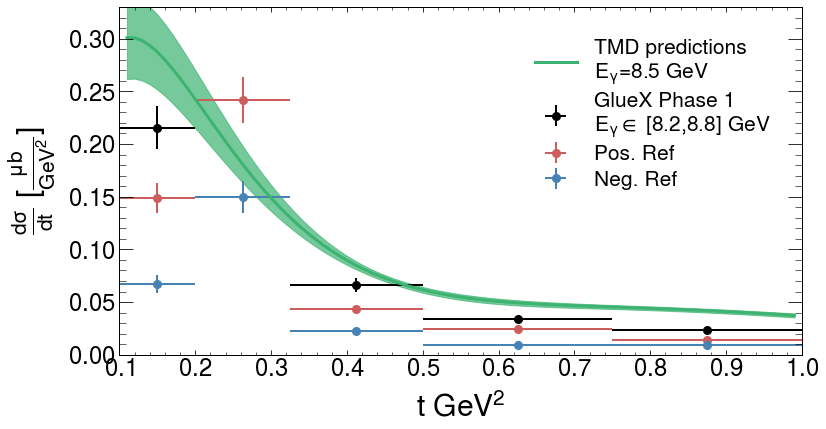

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


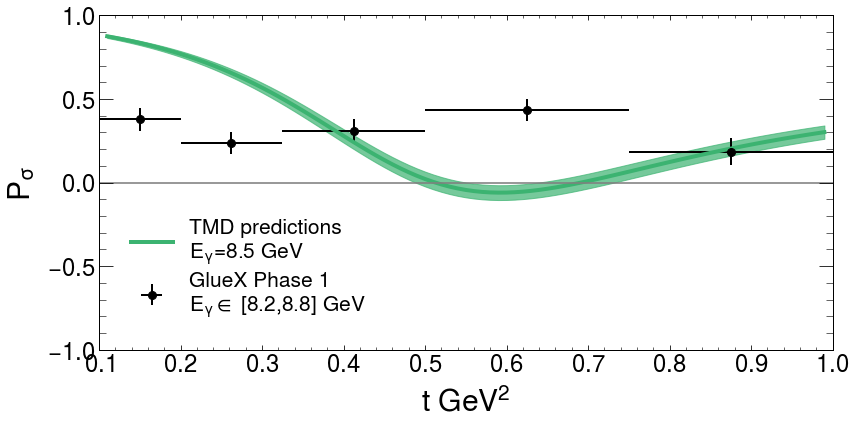

In [795]:
fig,axes=plt.subplots(1,1,figsize=(12,6))

arbitraryFactor=1
axes.errorbar(midts,crossSection,fmt='o',xerr=xerrs,yerr=crossSectionErr,c='black',
                 label="GlueX Phase 1\n$E_{\gamma}\in$ [8.2,8.8] GeV")
axes.errorbar(midts,crossSectionPos,fmt='o',xerr=xerrs,yerr=crossSectionPosErr,c='indianred',label="Pos. Ref")
axes.errorbar(midts,crossSectionNeg,fmt='o',xerr=xerrs,yerr=crossSectionNegErr,c='steelblue',label="Neg. Ref")
axes.set_xlabel(r"t $GeV^2$",size=30)
axes.set_ylabel(r"$\frac{d\sigma}{dt}$ [$\frac{\mu b}{GeV^2}$]",size=30)
axes.plot(crossSection_theory["t"],crossSection_theory["cs"]/arbitraryFactor,c="mediumseagreen",linewidth=3,
             label="TMD predictions\n$E_{\gamma}$=8.5 GeV")
axes.fill_between(crossSection_theory["t"],
                      (crossSection_theory["cs"]-crossSection_theory["cs_low_err"])/arbitraryFactor,
                      (crossSection_theory["cs"]+crossSection_theory["cs_up_err"])/arbitraryFactor,
                      color="mediumseagreen",alpha=0.7)
axes.tick_params(axis='both',labelsize=24)
axes.set_xlim(0.1)
axes.set_ylim(0,0.33)
axes.ticklabel_format(style='plain')
axes.legend(prop={"size":21})
plt.savefig(ofolder+"a2_xsec_m104180.pdf")

fig,axes=plt.subplots(1,1,figsize=(12,6))
axes.errorbar(midts,parityAsym,fmt='o',xerr=xerrs,yerr=parityAsymErr,c='black',label="GlueX Phase 1\n$E_{\gamma}\in$ [8.2,8.8] GeV")
axes.tick_params(axis='both',labelsize=24)
axes.set_xlabel(r"t $GeV^2$",size=30)
axes.set_ylabel(r"$P_{\sigma}$",size=30)
axes.plot(crossSection_theory["t"],crossSection_theory["pa"],c="mediumseagreen",linewidth=4,label="TMD predictions \n$E_{\gamma}$=8.5 GeV")
axes.fill_between(crossSection_theory["t"],
                      (crossSection_theory["pa"]-crossSection_theory["pa_low_err"])/arbitraryFactor,
                      (crossSection_theory["pa"]+crossSection_theory["pa_up_err"])/arbitraryFactor,
                      color="mediumseagreen",alpha=0.7)
axes.tick_params(axis='both',labelsize=24)
axes.set_xlim(0.1)
axes.set_ylim(-1,1)
axes.legend(prop={"size":21})
axes.axhline(0,c='gray',alpha=0.8,linestyle='-')

plt.tight_layout()

plt.savefig(ofolder+"a2_parityAsym_m104180.pdf")

# Experimental Resolution

In [287]:
runs=["2017_1","2018_1","2018_8"]

In [288]:
acc_df=[]
c_rec=["Mpi0eta","mandelstam_t","Ebeam","weightASBS"]
c_gen=["Mpi0eta_thrown","mandelstam_t_thrown","Ebeam_thrown"]

for run in runs:
    acc_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected/F"+run+"_selected_acc_flat.root","kin",cols=c_rec+c_gen))
acc_df=pd.concat(acc_df)

gen_df=[]
for run in runs:
    gen_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected/F"+run+"_gen_data_flat.root","kin",cols=c_gen))
gen_df=pd.concat(gen_df)

dat_df=[]
for run in runs:
    dat_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected/D"+run+"_selected_acc_flat.root","kin",cols=c_rec))
dat_df=pd.concat(dat_df)

In [289]:
def getResolution(i):
    tmp=acc_df[(acc_df.Mpi0eta_thrown<edges[i])&(acc_df.Mpi0eta_thrown>edges[i-1])]
    resolution=np.around(tmp.Mpi0eta.std(),6)
    return resolution

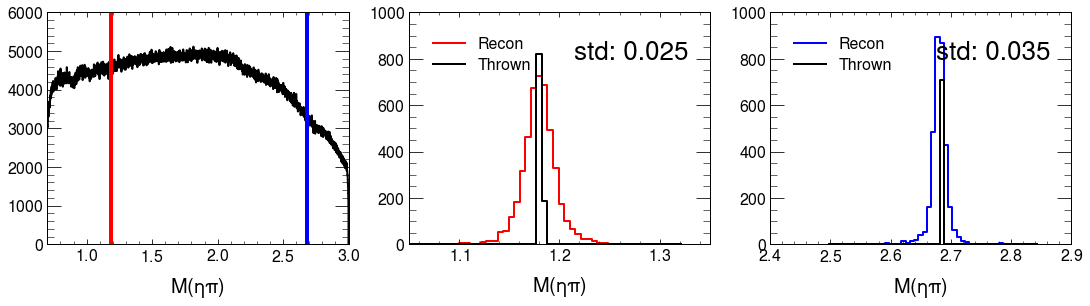

In [290]:
fig,axes=plt.subplots(1,3,figsize=(18,4))

edges=np.arange(acc_df.Mpi0eta_thrown.min(),acc_df.Mpi0eta_thrown.max(),step=0.001)
hep.histplot(np.histogram(acc_df.Mpi0eta,weights=acc_df.weightASBS,bins=edges),c='black',ax=axes[0])
axes[0].set_ylim(0)
axes[0].set_xlim(0.7,3)
axes[0].set_xlabel(r"$M(\eta\pi)$")

i=500
for iax, i, color in zip([1,2],[500,2000],["red","blue"]):
    axes[0].axvline(edges[i],c=color,linewidth=4)
    tmp=acc_df[(acc_df.Mpi0eta_thrown<edges[i])&(acc_df.Mpi0eta_thrown>edges[i-1])]
    _edges=np.linspace(tmp.Mpi0eta.min(),tmp.Mpi0eta.max(),50)
    hep.histplot(np.histogram(tmp.Mpi0eta,weights=tmp.weightASBS,bins=_edges),c=color,ax=axes[iax],label="Recon")
    axes[iax].text(0.55,0.8,f"std: {tmp.Mpi0eta.std():0.3f}", transform=axes[iax].transAxes, size=26)
    hep.histplot(np.histogram(tmp.Mpi0eta_thrown,weights=[0.1]*len(tmp),bins=_edges),c='black',ax=axes[iax],label="Thrown")
    axes[iax].set_ylim(0)
    axes[iax].set_xlabel(r"$M(\eta\pi)$")
    axes[iax].legend(loc=2)

In [291]:
centers=edges[:-1]+(edges[1]-edges[0])/2
resolution=[getResolution(i) for i in range(len(edges)-1)]

resolution=np.array(resolution)
centers=centers[~np.isnan(resolution)]
resolution=resolution[~np.isnan(resolution)]

/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


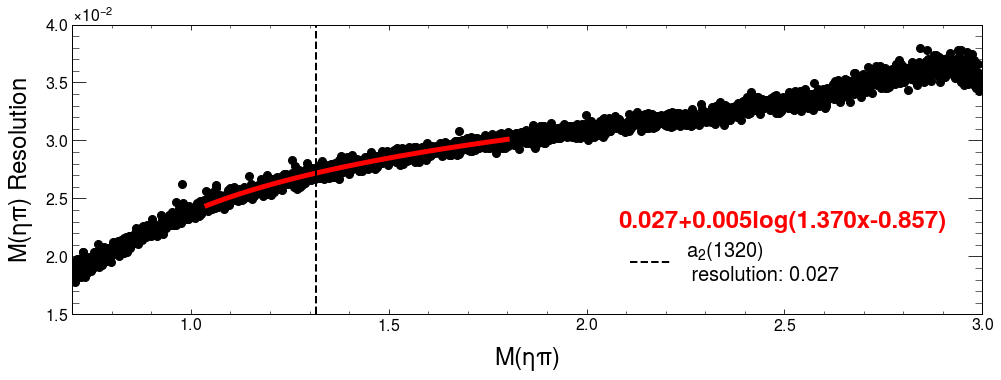

In [292]:
from scipy.optimize import curve_fit

def func(x, a, b, c, d):
    return a+b*np.log(c*x+d)

fig,axes=plt.subplots(1,1,figsize=(16,5))

axes.scatter(centers,resolution,c='black')
axes.set_xlim(0.7,3)

r=resolution[(centers>1.04)&(centers<1.80)]
x=centers[(centers>1.04)&(centers<1.80)]

popt, pcov = curve_fit(func, x, r, p0=(0.025,0.009,1.379,0.384))
a,b,c,d,=popt

axes.plot(x, func(x, *popt), 'r-', linewidth=5)

axes.text(0.6,0.3,f"{a:0.3f}+{b:0.3f}log({c:0.3f}x{d:0.3f})",transform=axes.transAxes,size=24,c='red',weight="bold")
axes.set_xlabel(r"$M(\eta\pi)$",size=24)
axes.set_ylabel("$M(\eta\pi)$ Resolution",size=24)
axes.axvline(1.317,c='black',linestyle='--', label=f"$a_2(1320)$\n resolution: {func(1.317,*popt):0.3f}")
axes.legend(prop={"size":20},loc=4,bbox_to_anchor=(0.875,0))

In [293]:
from scipy.special import voigt_profile as voigt

In [294]:
def relativistic_breit_wigner(x, resonance_mass, width):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

from scipy.stats import cauchy

(0.0, 8.0)

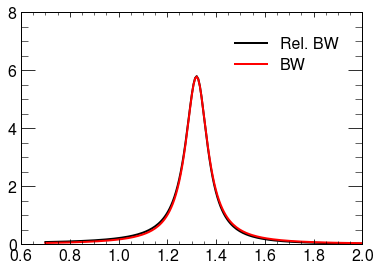

In [295]:
#############################################
# COMPARING REL. BW AND BW
#   IF THERE WAS A BIG DIFFERENCE WE WOULD HAVE TO CODE UP THE CONVOLUTION MANUALLY 
#   TO GET THE VOIGTIAN
#############################################

_x=np.linspace(0.7,2.0,200)
_m=1.32
_w=0.11

_y=relativistic_breit_wigner(_x,_m,_w)
_y2=cauchy.pdf(_x,loc=_m,scale=_w/2)

plt.plot(_x,_y,c='black',label="Rel. BW")
plt.plot(_x,_y2,c='red', label="BW")
plt.legend()
plt.ylim(0)

In [296]:
def fitMass(sigDistribtution):
    if sigDistribtution=="voigt":
        def signal(x,A,gamma):
            return A*voigt(x,0.027,gamma)
    elif sigDistribtution=="breitwigner":
        def signal(x,A,gamma):
            return A*voigt(x,0.00001,gamma)
    else:
        raise ValueError("argument must be [voigt,breitwigner]")
    
    def bkgnd(x,a,b):
        return a+b*x
    def func(x,A,gamma,a,b):
        return signal(x,A,gamma)+bkgnd(x,a,b)

    fig,axes=plt.subplots(2,3,figsize=(16,8),sharex=True,sharey=True)
    axes=axes.flatten()
    
    popts=[]
    pcovs=[]
    binwidths=[]
    xmin=1
    xmax=1.8
    for i,tmin,tmax in zip(range(5),[0.1,0.2,0.325,0.5,0.75],[0.2,0.325,0.5,0.75,1.0]):
        #########################
        # LOAD AND BIN THE DAT, ACC, GEN DATASETS
        #########################
        tmp_dat_df=dat_df[(dat_df.mandelstam_t>tmin)&(dat_df.mandelstam_t<tmax)]
        tmp_acc_df=acc_df[(acc_df.mandelstam_t>tmin)&(acc_df.mandelstam_t<tmax)&(acc_df.mandelstam_t_thrown>tmin)&(acc_df.mandelstam_t_thrown<tmax)]
        tmp_gen_df=gen_df[(gen_df.mandelstam_t_thrown>tmin)&(gen_df.mandelstam_t_thrown<tmax)]

        #########################
        # BIN AND ACCEPTANCE CORRECT THE DATA
        #########################
        edges2=np.linspace(xmin,xmax,51) # nbins+1
        centers2=edges2[:-1]+(edges2[1]-edges2[0])/2
        counts_dat,_=np.histogram(tmp_dat_df.Mpi0eta,weights=tmp_dat_df.weightASBS,bins=edges2)
        counts_acc,_=np.histogram(tmp_acc_df.Mpi0eta,weights=tmp_acc_df.weightASBS,bins=edges2)
        counts_gen,_=np.histogram(tmp_gen_df.Mpi0eta_thrown,bins=edges2)
        counts2=counts_dat*counts_gen/counts_acc # acceptance corrected
        avgEff=(counts_acc/counts_gen).mean()

        hep.histplot((counts2,edges2),c='black',ax=axes[i])
        axes[i].set_ylim(0)

        a2_peak=1.31
        c2=counts2[(centers2>1.1)&(centers2<1.55)]
        c2err=np.sqrt(c2)
        x2=centers2[(centers2>1.1)&(centers2<1.55)]-a2_peak

        #popt2, pcov2 = curve_fit(func, x2, c2, sigma=np.sqrt(c2), p0=(1000,0.1,500,-5000))
        popt2, pcov2 = curve_fit(func, x2, c2, sigma=c2err, p0=(1.802e+03,  2.687e-02,  1.1074e+04, -2.622e+04))
        A,gamma,a,b=popt2
        popts.append(popt2)
        pcovs.append(pcov2)
        width=edges2[1]-edges2[0]
        binwidths.append(width)
        
        residuals=(counts2[(centers2>1.1)&(centers2<1.55)]-func(x2, *popt2))/c2err
        chiSq=(residuals**2).sum()
        dof=len(x2)-4
        reducedChiSq=chiSq/dof

        axes[i].plot(x2+a2_peak, func(x2, *popt2), color='red', linestyle='-', linewidth=2)
        axes[i].plot(x2+a2_peak, bkgnd(x2, *popt2[2:]), color='blue', linestyle='--', linewidth=2)
        axes[i].plot(x2+a2_peak, signal(x2, *popt2[:2]), color='magenta', linestyle='--', linewidth=2)

        axes[i].text(0.4,0.85,tLabels[i],size=24,transform=axes[i].transAxes)
        axes[i].text(0.6,0.75,f"Yield: {popt2[0]/width/1000:0.1f}k", size=18, transform=axes[i].transAxes)
        axes[i].text(0.6,0.65,f"FWHM: {2*popt2[1]:0.3f}", size=18, transform=axes[i].transAxes)
        axes[i].text(0.6,0.55,f"AvgEff: {avgEff:0.3f}", size=18, transform=axes[i].transAxes)
        axes[i].text(0.6,0.45,r"$\chi_{{{}}}^2$: {:0.2f}".format("red.",reducedChiSq), size=18, transform=axes[i].transAxes)

    axes[4].set_xlabel(r"$M(\eta\pi)$ GeV",size=30)
    axes[0].set_ylabel(f"Entries / {edges2[1]-edges2[0]:0.2f}",size=30)
    axes[0].yaxis.set_label_coords(-0.1, 0.0)
    axes[0].set_xlim(xmin,xmax)
    axes[1].set_title("Acceptance Corrected",size=30)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    
    simpleFit_corrected_yield_errs = np.array([np.sqrt(np.diag(pcovs[i]))[0]/binwidths[0] for i in range(5)])
    simpleFit_corrected_yields=np.array([popts[i][0]/binwidths[0] for i in range(5)])
    
    return simpleFit_corrected_yields, simpleFit_corrected_yield_errs

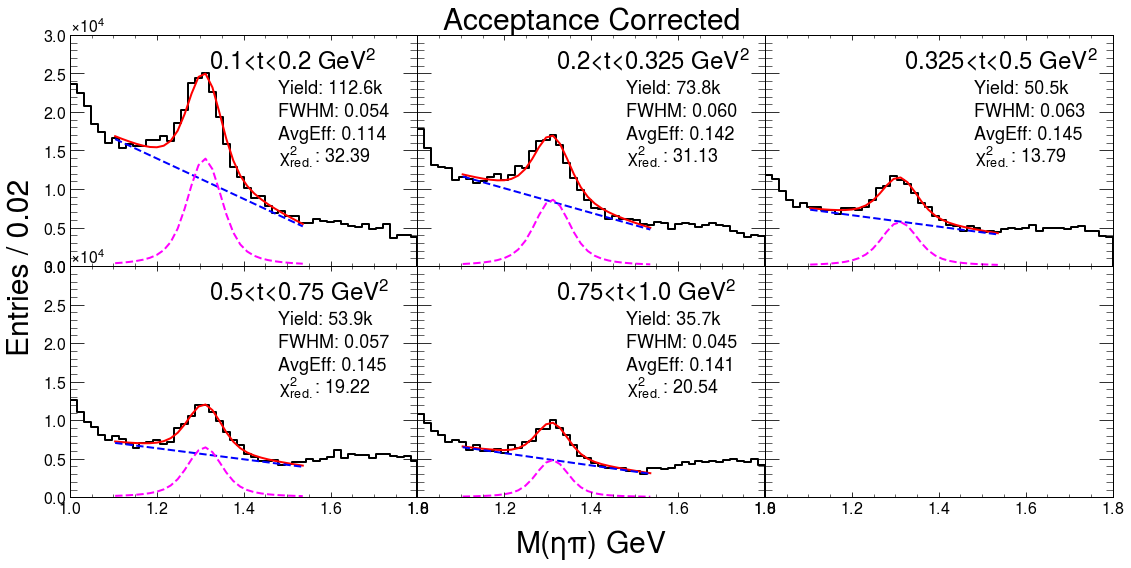

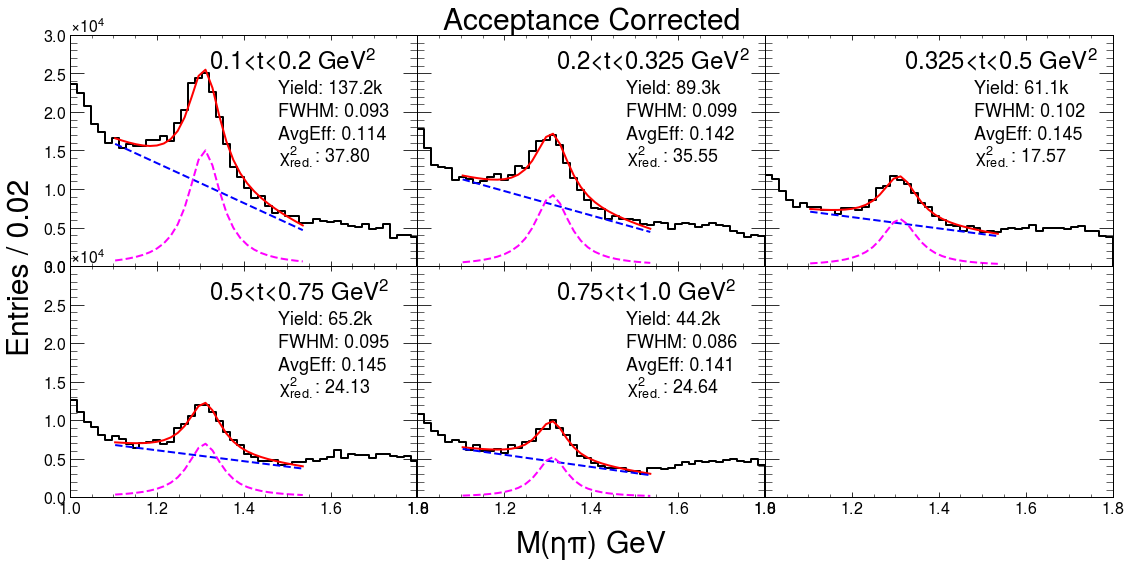

In [297]:
voigtFit_corrected_yields, voigtFit_corrected_yield_errs=fitMass("voigt")
bwFit_corrected_yields, bwFit_corrected_yield_errs=fitMass("breitwigner")

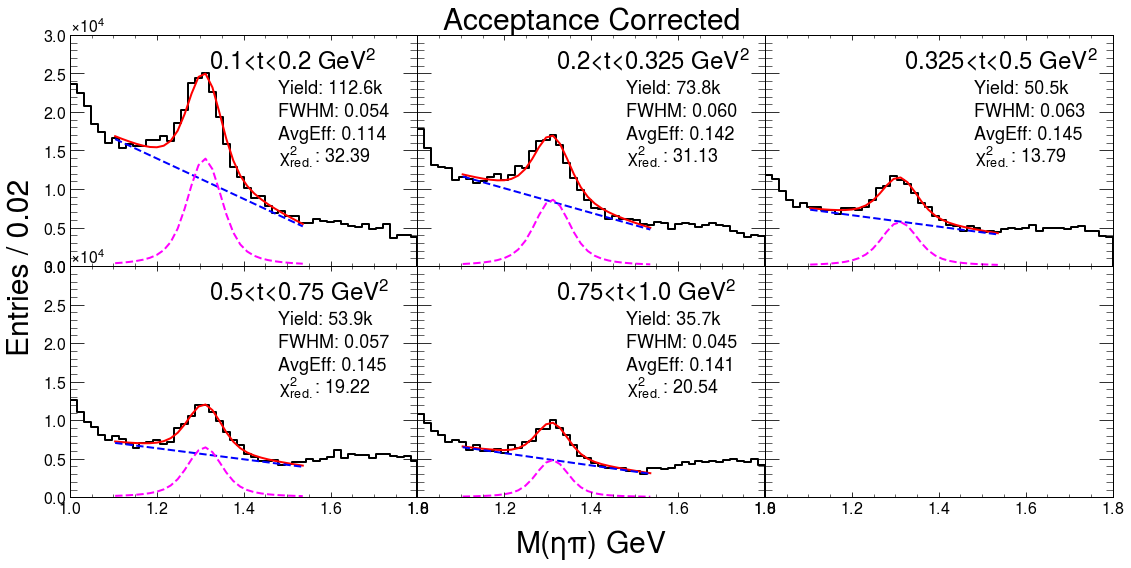

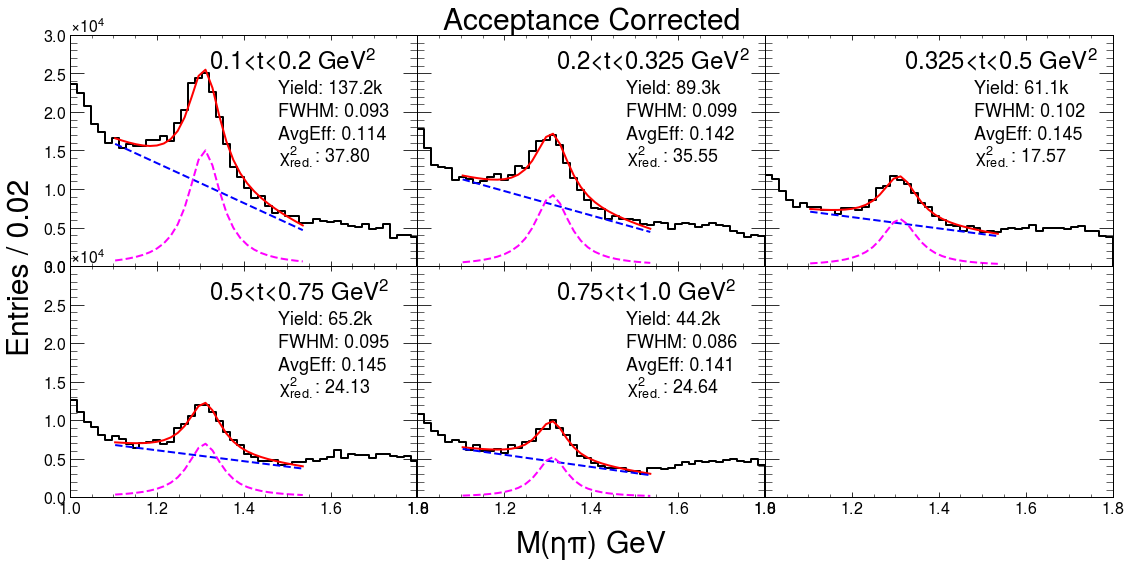

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


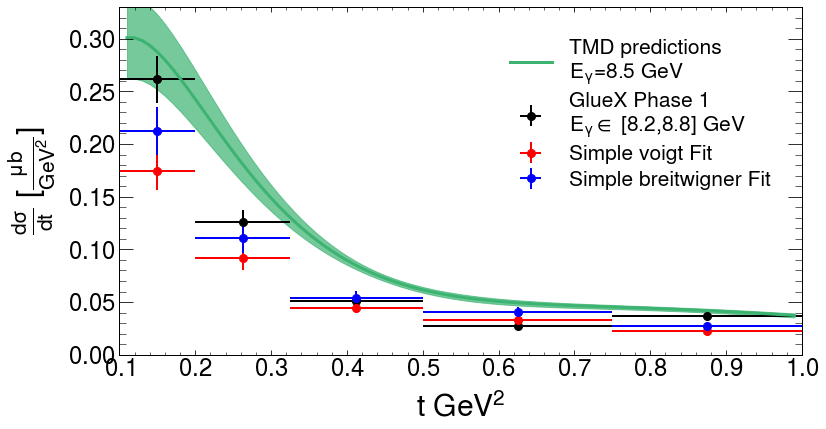

In [298]:
## Polarized flux basically no error bars 
simpleFits=[voigtFit_corrected_yields,bwFit_corrected_yields]
simpleFitErrs=[voigtFit_corrected_yield_errs,bwFit_corrected_yield_errs]
dists=["voigt","breitwigner"]

cs={}
csErrs={}
for simpleFit_crossSection, simpleFit_crossSectionErr,dist in zip(simpleFits,simpleFitErrs,dists):
    simpleFit_corrected_yields, simpleFit_corrected_yield_errs = fitMass(dist)
    simpleFit_crossSection=simpleFit_corrected_yields/phase1_polarized_flux/target/a2FullReact_br[0]/tBinWidths
    simpleFit_crossSectionErr=simpleFit_crossSection*np.sqrt( 
        (simpleFit_corrected_yield_errs/simpleFit_corrected_yields)*(simpleFit_corrected_yield_errs/simpleFit_corrected_yields)+
        (a2FullReact_br[1]/a2FullReact_br[0])*(a2FullReact_br[1]/a2FullReact_br[0])
                                        )
    # nb to microbarns
    simpleFit_crossSection/=1000
    simpleFit_crossSectionErr/=1000
    
    cs[dist]=simpleFit_crossSection
    csErrs[dist]=simpleFit_crossSectionErr


fig,axes=plt.subplots(1,1,figsize=(12,6))

arbitraryFactor=1
axes.errorbar(midts,crossSection,fmt='o',xerr=xerrs,yerr=crossSectionErr,c='black',
                 label="GlueX Phase 1\n$E_{\gamma}\in$ [8.2,8.8] GeV")
for dist,color in zip(dists,['red','blue']):
    axes.errorbar(midts,cs[dist],fmt='o',xerr=xerrs,yerr=csErrs[dist],c=color,
                     label="Simple "+dist+" Fit")
axes.set_xlabel(r"t $GeV^2$",size=30)
axes.set_ylabel(r"$\frac{d\sigma}{dt}$ [$\frac{\mu b}{GeV^2}$]",size=30)
axes.plot(crossSection_theory["t"],crossSection_theory["cs"]/arbitraryFactor,c="mediumseagreen",linewidth=3,
             label="TMD predictions\n$E_{\gamma}$=8.5 GeV")
axes.fill_between(crossSection_theory["t"],
                      (crossSection_theory["cs"]-crossSection_theory["cs_low_err"])/arbitraryFactor,
                      (crossSection_theory["cs"]+crossSection_theory["cs_up_err"])/arbitraryFactor,
                      color="mediumseagreen",alpha=0.7)
axes.tick_params(axis='both',labelsize=24)
axes.set_xlim(0.1)
axes.set_ylim(0,0.33)
axes.ticklabel_format(style='plain')
axes.legend(prop={"size":21})
# plt.savefig("a2_xsec_m104180.pdf")

In [299]:
[f"{ele*100:0.1f}%" for ele in (cs['breitwigner']-cs['voigt'])/cs['breitwigner']]

['17.9%', '17.3%', '17.4%', '17.3%', '19.3%']

/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


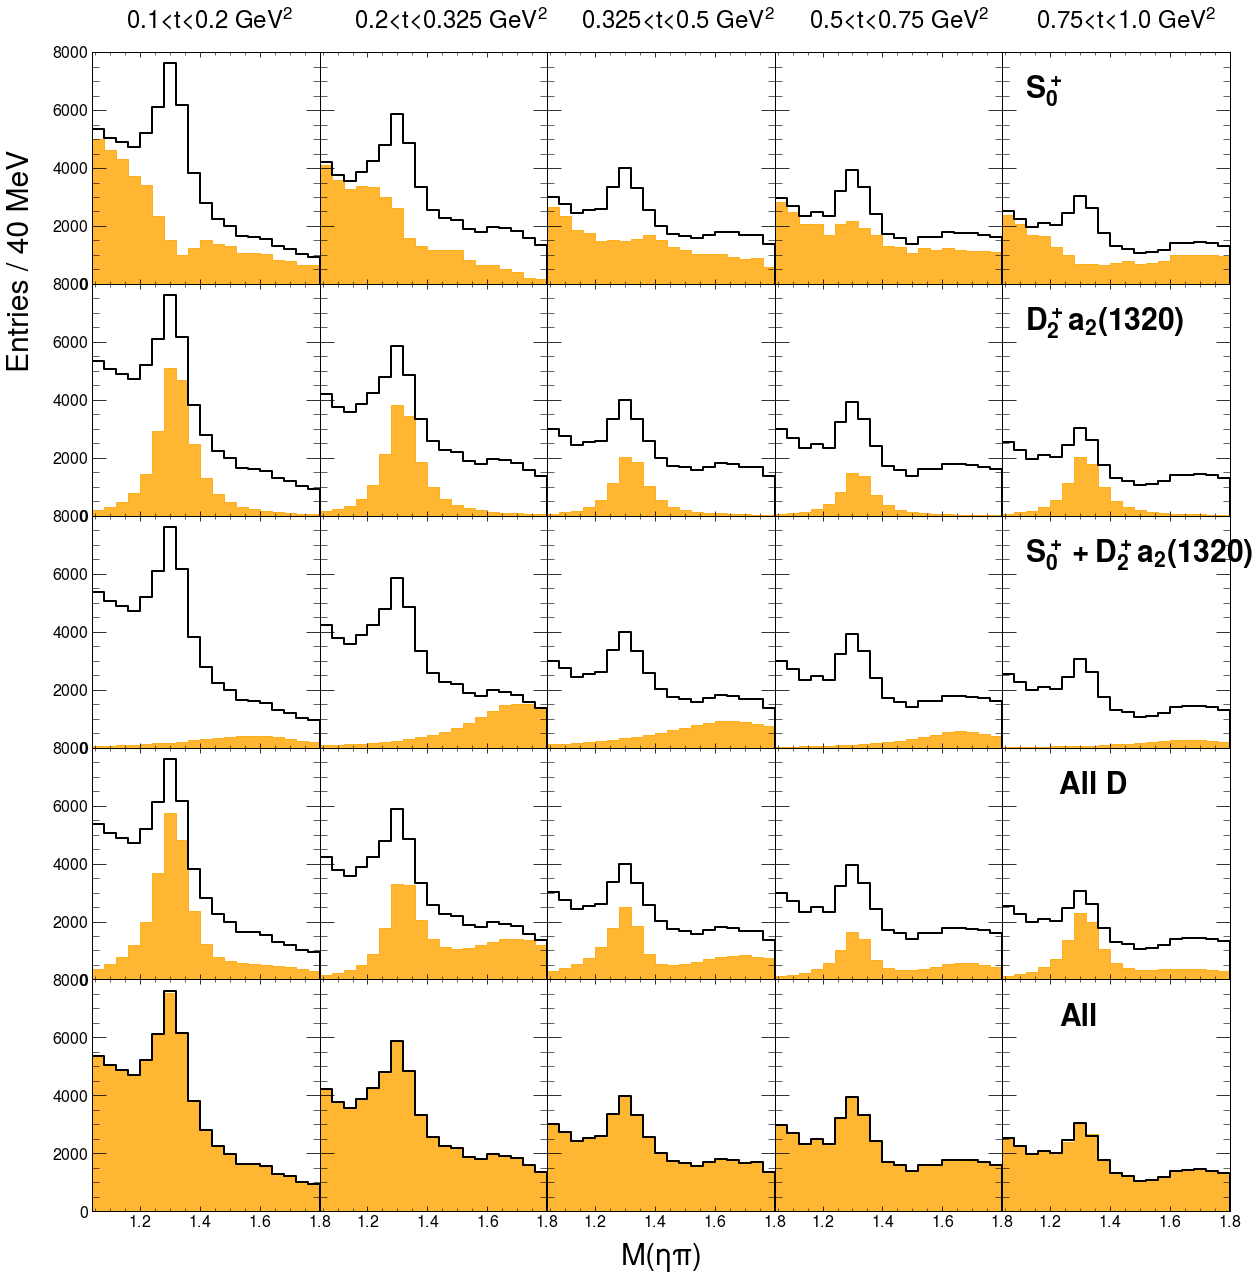

In [300]:
fileName="etapi_plot_"
md_floc="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/nominal/"

waves=["S0+-_S0++",
       "D1--_D0+-_D1+-_D0++_D1++_D2++",
       "pD1--_pD0+-_pD1+-_pD0++_pD1++_pD2++",
       "D1--_D0+-_D1+-_D0++_D1++_D2++_pD1--_pD0+-_pD1+-_pD0++_pD1++_pD2++",
       "S0+-_S0++_D1--_D0+-_D1+-_D0++_D1++_D2++_pD1--_pD0+-_pD1+-_pD0++_pD1++_pD2++"
      ]

fig,axes=plt.subplots(5,5,figsize=(20,20),sharex=True,sharey=True)

for it, t in enumerate(ts):
    for iw, selectWave in enumerate(waves):
        histdat, _, width = loadMergedPols(md_floc+t+"/"+fileName+"D2++.root","Metapi_40MeVBindat",["000","045","090","135"])
        histacc, _, widthacc = loadMergedPols(md_floc+t+"/"+fileName+"D2++.root","Metapi_40MeVBinacc",["000","045","090","135"])
        binScaleFactor=width/widthacc

        fileLoc=md_floc+t+"/"+fileName+selectWave+".root"
        histdat,edges,_=loadMergedPols(fileLoc,"Metapi_40MeVBindat",["000","045","090","135"])
        histbkg,_,_=loadMergedPols(fileLoc,"Metapi_40MeVBinbkg",["000","045","090","135"])
        values=histdat-histbkg
        histacc,edgesacc,_=loadMergedPols(fileLoc,"Metapi_40MeVBinacc",["000","045","090","135"])
        valuesacc=histacc*binScaleFactor
        xmin=edges[:-1][histdat>0][0] # edges has 1 more dimension than the counts, need to account for that
        xmax=edges[1:][histdat>0][-1]
        axes[iw,it].set_xlim(xmin,xmax)
        axes[iw,it].set_ylim(0,8000)

        hep.histplot(values,edges,c='black',ax=axes[iw,it])
        hep.histplot(valuesacc,edgesacc,color="orange",ax=axes[iw,it],alpha=0.8,histtype='fill')

## Draw text with t-bin
for ax,tLabel in zip(axes.flatten()[:5],tLabels):
    plt.text(0.15, 1.1, tLabel, fontsize=24, transform=ax.transAxes)

axes[-1,2].set_xlabel(r"$M(\eta\pi)$",size=30)
axes[0,0].set_ylabel("Entries / 40 MeV",size=30)
axes[0,0].yaxis.set_label_coords(-0.25, 0.1)
axes[0,4].text(0.1,0.8,r"$S_0^+$",size=30,weight='bold',transform=axes[0,4].transAxes)
axes[1,4].text(0.1,0.8,r"$D_2^+ a_2(1320)$",size=30,weight='bold',transform=axes[1,4].transAxes)
axes[2,4].text(0.1,0.8,r"$S_0^+ + D_2^+ a_2(1320)$",size=30,weight='bold',transform=axes[2,4].transAxes)

axes[3,4].text(0.25,0.8,"All D",size=30,weight='bold',transform=axes[3,4].transAxes)
axes[4,4].text(0.25,0.8,"All",size=30,weight='bold',transform=axes[4,4].transAxes)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)


# plt.savefig(ofolder+ref+"_"+ofileTag+".pdf")

# Phase Study

This study shows that calculating the phases with atan2 might not be the best. It can create discontinuities in the phase motion due to atan2 being restricted to [-pi, pi]. the phase difference is not required to have a domain span of 2pi

I think a better way to do it is to normmalize the amps and take i*log(im/re) guarentees domain span of 2pi

In [320]:
#################
# Basic Setup
#################
mi_lowMass=0.8
mi_upMass=1.8
mi_nbins=25
mi_waveset="D0+_D0-_D2+_D2-_S0+_S0-"
mi_waveset_vec=mi_waveset.split("_")
mi_waveset_vec=[rearrangeWaveNotation[ele] for ele in mi_waveset_vec]

mi_baseFolder="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr/"

mi_df=loadMassIndependentData(mi_baseFolder,mi_waveset,
                              np.linspace(mi_lowMass,mi_upMass,mi_nbins+1),keep=[False,False,False])

loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr/finalAmps/D0+_D0-_D2+_D2-_S0+_S0-
	t - total entries pre filtering 750
	t - total entries post filtering 750


In [388]:
def getPhaseDiff(method):
    if method==1:
        phaseS0p=np.arctan2(mi_df["ImS0+"],mi_df["ReS0+"])
        phaseD2p=np.arctan2(mi_df["ImD2+"],mi_df["ReD2+"])
        phaseDiff=phaseD2p-phaseS0p
        phaseDiff=np.abs(phaseDiff)
    elif method==2:
        s0p=(mi_df["ReS0+"]+1j*mi_df["ImS0+"])
        d2p=(mi_df["ReD2+"]+1j*mi_df["ImD2+"])
        s0p/=s0p.abs()
        d2p/=d2p.abs()
        phaseDiff=1j*np.log(d2p/s0p)
        phaseDiff=np.real(phaseDiff)
        phaseDiff=np.abs(phaseDiff)
    return phaseDiff

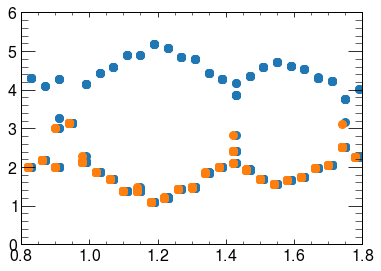

In [390]:
plt.scatter(mi_df.mass+0.01, getPhaseDiff(1),label="nominal")
plt.scatter(mi_df.mass, getPhaseDiff(2),label="new")